In [1]:
#!/usr/bin/py
import sklearn
import logging
import os
import warnings
import numpy as np
import tsfel
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime
from zipfile import ZipFile, is_zipfile
import matplotlib.pyplot as plt
import pandas as pd
import math
import tsfresh
from tsfresh.utilities.distribution import MultiprocessingDistributor
import seaborn as sns

In [2]:
HEADER_LINE_PREFIX = '% '
HEADER_END_LINE_PREFIX = '%-'
HEADER_KEYS = ['date_time', 'prog_version', 'serial', 'mech_unit', 'axis', 'sampling_period', 'tool', 'rob_ax', 'ext_ax']
DATETIME_FORMAT = '%Y%m%d_%H%M%S'

MIN_SAMPLES = 600
SAMPLING_PERIOD = 0.004032
FREQUENCY = 1/SAMPLING_PERIOD

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()



In [3]:
MccRun = namedtuple('MccRun', 'mode series')
MccResult = namedtuple('MccResult', 'status value average distance')
OperationMode = namedtuple('OperationMode', ['axis', 'mech_unit', 'tool', 'rob_ax', 'ext_ax', 'prog_version'])

In [4]:
@contextmanager
def open_zip(file):
    if not is_zipfile(file):
        raise TypeError(f'{file} is not a valid zip file')

    zip_archive = ZipFile(file, 'r')
    files = zip_archive.namelist()
    try:
        extracted = [zip_archive.open(f) for f in files]
        yield extracted
    finally:
        for f in extracted:
            f.close()
        zip_archive.close()

In [5]:
def read_header(file):
    header = {}
    for line in file:
        line = line.decode('utf-8')
        if line.startswith(HEADER_LINE_PREFIX):
    
            parameter, value = (element.strip() for element in line.split(':'))
            if 'Meas time' in parameter:
                header['date_time'] = datetime.strptime(value, DATETIME_FORMAT)
            if 'Program version' in parameter:
                header['prog_version'] = value
            elif 'Robot serial number' in parameter:
                header['serial'] = value
            elif 'Mech unit' in parameter:
                header['mech_unit'] = value
            elif 'Axis' in parameter:
                header['axis'] = int(value)
            elif 'Sample time' in parameter:
                header['sampling_period'] = float(value)
            elif 'Tool' in parameter:
                header['tool'] = value
            elif 'RobAx' in parameter:
                header['rob_ax'] = value
            elif 'ExtAx' in parameter:
                header['ext_ax'] = value
            elif 'Meas type' in parameter:
                continue
            else:
                #logging.debug(f'Parameter {parameter} and value {value} not handled')
                continue

        elif line.startswith(HEADER_END_LINE_PREFIX):
            continue

        else:
            break
#     if not header:
#         logging.warning(f'Empty header in {file.name}')
#         return None
    return header

In [6]:
def read_data(file):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            data = np.loadtxt(file, dtype=np.float64, delimiter='\t')
        except Warning:
            logging.warning(f'{file.name} has no data')
            return None
#         except Exception:
#             logging.error(f'{file.name} is broken')
            return None

    n_samples, n_columns = data.shape

    if n_columns == 3:
        data = _decrypt3(data)
    elif n_columns == 4:
        data = _decrypt3(data[:, 1:]) 
    elif n_columns == 5:
        data = _decrypt4(data[:, 1:])
    else:
        logging.warning(f'Unhandled case with {n_columns} columns in {handle.name}')
        return None
    if n_samples < MIN_SAMPLES:
        logging.warning(f'Case with {n_samples} samples')

    data = data[10:-10]
    return np.asarray(data)
def _decrypt3(data):
    return data * np.matrix([[0.5, 0.5, 0], [-0.5, 0, 0.5], [0, 0.5, -0.5]])


def _decrypt4(data):
    return data * np.matrix([[0.5, 0.5, 0, 0], [-0.5, 0, 0, 0.5], [0, 0, 0.5, -0.5], [0, 0.5, -0.5, 0]])

In [7]:

class MccTimeSeries():
    def __init__(self, series, date_time, sampling_period):
        self.series = series
        self.date_time = date_time
        self.sampling_period = sampling_period
    
    def __getitem__(self, index):
        return self.series[index]

    def __len__(self):
        return len(self.series)

    @property
    def torque_ff(self):
        return self.series[:, 0]

    @property
    def velocity(self):
        return self.series[:, 1]
    
    @property
    def torque(self):
        return self.series[:, 2]

    @property
    def time_index(self):
        return np.arange(0, self.torque.size)[:, np.newaxis] * self.sampling_period

    @property
    def sampling_frequency(self):
        return 1 / self.sampling_period

    def normalized_torque(self):
        return (self.torque - self.torque.min()) / (self.torque.max() - self.torque.min())
    
    def standardized_torque(self):
        return (self.torque - self.torque.mean()) / self.torque.std()
    def mean_torque(self):
        return self.torque.mean()
    

        
    
    

In [8]:
def calcuate_RMS_Value(data,axis,file):
    RMS_Value = []
    d = []

    if axis in file:
                # Extract features for axis1
        print(file)
        
        data = series.normalized_torque()
        d = np.concatenate((data, d), axis=None)
        RMS_Value.append(tsfresh.feature_extraction.feature_calculators.root_mean_square(d))
        return RMS_Value

In [9]:
from pyitlib import discrete_random_variable as drv
def find_reference_point(route):
    with ZipFile(route) as File:
        for file in File.namelist():
            with File.open(file) as f:
                header = read_header(f)
                data = read_data(f)
                
                mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                if ax1 in file:
                    ref1 = series.normalized_torque()
                elif ax2 in file:
                    ref2 = series.normalized_torque()                    
                elif ax3 in file:
                    ref3 = series.normalized_torque()
                elif ax4 in file:
                    ref4 = series.normalized_torque()
                elif ax5 in file:
                    ref5 = series.normalized_torque()
                elif ax6 in file:
                    ref6 = series.normalized_torque()
    return ref1,ref2,ref3,ref4,ref5,ref6

In [10]:
# File_test = '04-64139_DIAGDATA_20170920_180212__MCC.zip'
# feature_list_axis1 = []
# d = []

# from datetime import timedelta
# with ZipFile(File_test) as File:
#     print(File_test)
#     for file in File.namelist():
#         print(file)
#         with File.open(file) as f:
#             header = read_header(f)
#             date = header['date_time']
#             print(date.date())
#             data = read_data(f)
#             mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])
#             series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
#             a = date(2016, 5, 9)
#             print(a)
#             plt.figure(figsize=(10,2)) 
#             t = series.normalized_torque()
#             d = np.concatenate((t, d), axis=None)
            
#             time_index = series.time_index
#             plt.plot(time_index, t)
#             plt.show()   
#             #Caculate RMS
#             test = tsfresh.feature_extraction.feature_calculators.root_mean_square(d)
#             print(test)
#             # Extract features for axis1
           
#             feature_list_axis1.append(tsfel.time_series_features_extractor(cfg, d))
#             result = pd.concat(feature_list_axis1)
#             print(date)
                
            


In [11]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
RMS_Value=pd.DataFrame(columns=columns)
Skewness_value = pd.DataFrame(columns=columns)
Kurtosis_value = pd.DataFrame(columns=columns)
Crest_factor = pd.DataFrame(columns=columns)
Energy = pd.DataFrame(columns=columns)
Stv = pd.DataFrame(columns=columns)
Variance = pd.DataFrame(columns=columns)
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    print(route)
    if '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip' in route:
        ref1,ref2,ref3,ref4,ref5,ref6 = find_reference_point(route)
    else:    
        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    #Set the index
                    date = header['date_time']
                    i = date.date()
                    #Read data
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        d1 = series.normalized_torque()
                        RMS_Value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d1-ref1)
                        Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1-ref1)
                        Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1-ref1)
                        Energy.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d1-ref1)
                        Stv.loc[i, 'axis1'] = (d1-ref1).std(ddof=0)
                        Variance.loc[i, 'axis1'] = (d1-ref1).var()
                        Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1-ref1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1-ref1)
                    elif ax2 in file:
                    # Extract features for axis1
                        d2 = series.normalized_torque()
                        RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2-ref2)
                        Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2-ref2)
                        Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2-ref2)
                        Energy.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d2-ref2)
                        Stv.loc[i, 'axis2'] = (d2-ref2).std(ddof=0)
                        Variance.loc[i, 'axis2'] = (d2-ref2).var()
                        Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2-ref2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2-ref2)
                    elif ax3 in file:
                    # Extract features for axis1
                        d3 = series.normalized_torque()
                        RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3-ref3)
                        Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3-ref3)
                        Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3-ref3)
                        Stv.loc[i, 'axis3'] = (d3-ref3).std(ddof=0)
                        Variance.loc[i, 'axis3'] = (d3-ref3).var()
                        Energy.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d3-ref3)
                        Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3-ref3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3-ref3)
                    elif ax4 in file:
                    # Extract features for axis1
                        d4 = series.normalized_torque()
                        RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4-ref4)
                        Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4-ref4)
                        Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4-ref4)
                        Energy.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d4-ref4)
                        Stv.loc[i, 'axis4'] = (d4-ref4).std(ddof=0)
                        Variance.loc[i, 'axis4'] = (d4-ref4).var()
                        Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4-ref4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4-ref4)
                    elif ax5 in file:
                    # Extract features for axis1
                        d5 = series.normalized_torque()
                        RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5-ref5)
                        Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5-ref5)
                        Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5-ref5)
                        Energy.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d5-ref5)
                        Stv.loc[i, 'axis5'] = (d5-ref5).std(ddof=0)
                        Variance.loc[i, 'axis5'] = (d5-ref5).var()
                        Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5-ref5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5-ref5)
                    elif ax6 in file:
                    # Extract features for axis1
                        d6 = series.normalized_torque()
                        RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6-ref6)
                        Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6-ref6)
                        Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6-ref6)
                        Energy.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.abs_energy(d6-ref6)
                        Stv.loc[i, 'axis6'] = (d6-ref6).std(ddof=0)
                        Variance.loc[i, 'axis6'] = (d6-ref6).var()
                        Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6-ref6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6-ref6)
        
               

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170918_180042__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170918_MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_000033__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_060041__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_120031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170919_180311__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_000038__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_060026_

C:\Temp\ipykernel_12792\3819760366.py:37: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1-ref1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1-ref1)
C:\Temp\ipykernel_12792\3819760366.py:47: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2-ref2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2-ref2)
C:\Temp\ipykernel_12792\3819760366.py:57: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3-ref3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3-ref3)
C:\Temp\ipykernel_12792\3819760366.py:67: RuntimeWarning: invalid value encountered in double_scalars
  Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extrac

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_120037__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170920_180212__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170921_000031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170921_120021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170921_180210__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_000030__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_060025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_120023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20170922_180220__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171010_230023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_050009__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_110016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_170202__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171011_230022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_050010__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_110016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_170201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171012_230024__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171104_060018__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171104_120025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171104_180210__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_000217__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_060358__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_120222__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171105_180423__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171106_000215__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171106_060223__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171124_120016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171124_180203__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_000022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_060025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_120013__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171125_180209__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_000011__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_060205__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171126_120025__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171218_000118__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171218_060121__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171218_120127__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171218_180313__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_000114__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_060122__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_120109__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171219_180304__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20171220_000107__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180108_180245__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_000046__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_060050__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_120048__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180109_180245__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_000043__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_060041__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_120034__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180110_180031__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180130_180255__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180131_000105__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180131_060108__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180131_180243__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_000104__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_060104__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_120058__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180201_180233__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180202_000051__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180222_120014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180222_180201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_000014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_060012__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_120023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180223_180201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180224_000015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180224_060015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180224_120017__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180319_180148__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_000007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_060002__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_120004__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180320_180159__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180321_000020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180321_060015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180321_120010__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180321_180005__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180409_170210__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180409_230020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_050016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_110043__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_170029__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180410_230211__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180411_050027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180411_110041__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180411_170224__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180430_230026__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_050011__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_110018__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_170217__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180501_230024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180502_050020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180502_110045__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180502_170205__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180502_230013__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180521_170206__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180521_230017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_050024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_110021__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_170216__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180522_230033__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180523_050033__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180523_110028__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180523_170213__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180611_170007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180611_230016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_050024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_110019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_170203__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180612_230014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180613_050032__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180613_110027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180613_170222__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180630_230027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_050200__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_110019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_170017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180701_230201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_050027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_110012__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_170207__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180702_230023__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180816_110036__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180816_170212__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180817_110031__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180817_170023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180817_230215__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180820_170032__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180820_230116__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180821_110034__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180821_170220__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180926_110013__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180926_170209__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180926_230018__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_050027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_110013__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_170209__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180927_230019__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180928_050007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20180928_170207__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181021_050034__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181021_110044__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181021_170042__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181021_230227__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_050042__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_110042__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_170228__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181022_230036__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181023_050043__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181218_000020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181218_060016__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181218_120022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181218_180207__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20181219_000015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190108_021517__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190108_021639__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190108_055950__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190108_115957__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190201_000025__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_021352__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_021548__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_021557__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_021601__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_060017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_120029__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190202_180027__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190203_000211__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190222_120017__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190222_180203__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190223_000203__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190223_060020__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190223_120014__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190223_180201__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190224_000022__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190224_060026__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190224_120021__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190316_180010__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190317_000200__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190317_060007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190317_120213__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190317_180023__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_000318__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_060015__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_120024__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190318_180021__MCC.zip
C:/Users/semihua/De

C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190424_110008__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190424_170153__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190424_230001__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_045957__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_110054__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_170149__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190425_225959__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190426_050007__MCC.zip
C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139\04-64139_DIAGDATA_20190426_110004__MCC.zip
C:/Users/semihua/De

In [12]:
# for loop_file in os.listdir(File_path):
#     route = os.path.join(File_path,loop_file)
#     with ZipFile(route) as File:
#         for file in File.namelist():
#             with File.open(file) as f:
#                 header = read_header(f)
#                 #Set the index
#                 date = header['date_time']
#                 i = date.date()
#                 #Read data
#                 data = read_data(f)
#                 mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
#                 series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
#                 if ax1 in file:
#                 # Extract features for axis1
#                     DATA1 = series.normalized_torque()
#                     d1 = np.concatenate((d1,DATA1), axis=None)
#                     print(d1)
#                     break

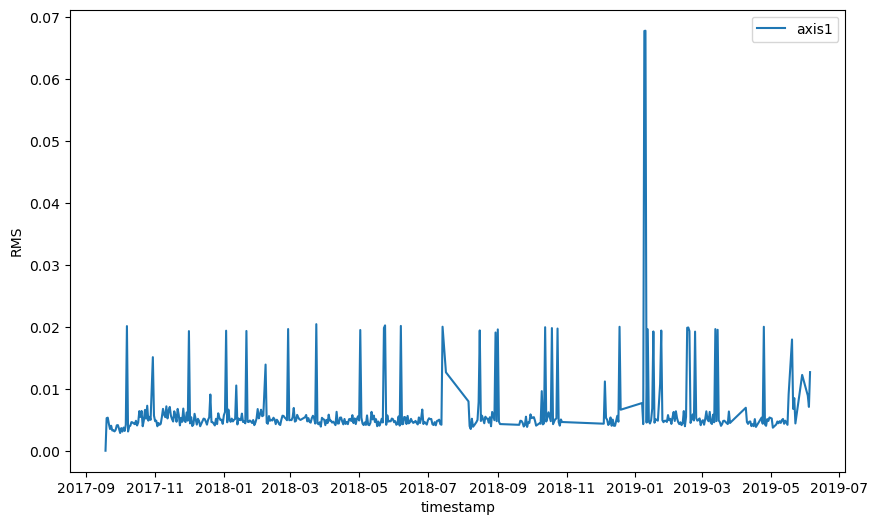

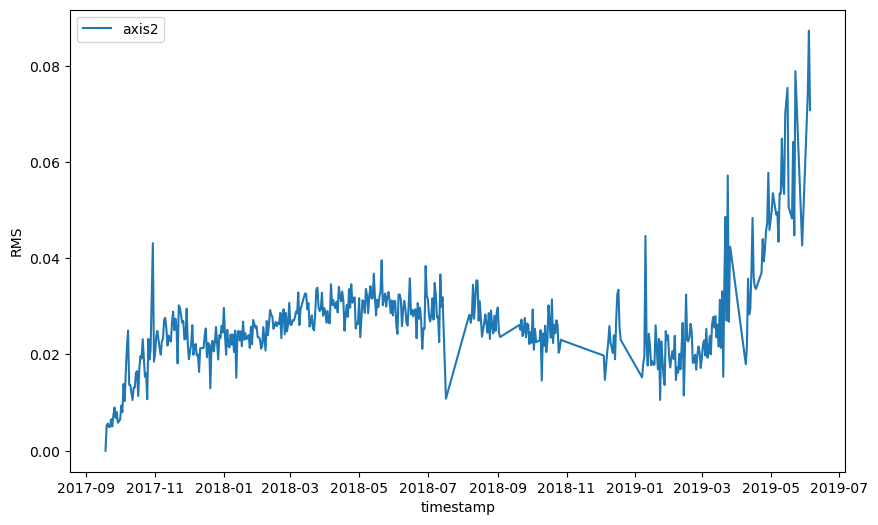

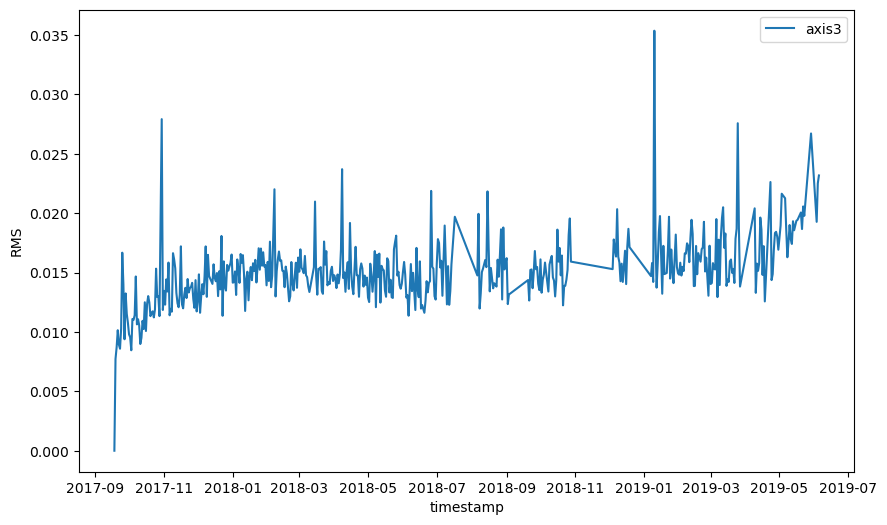

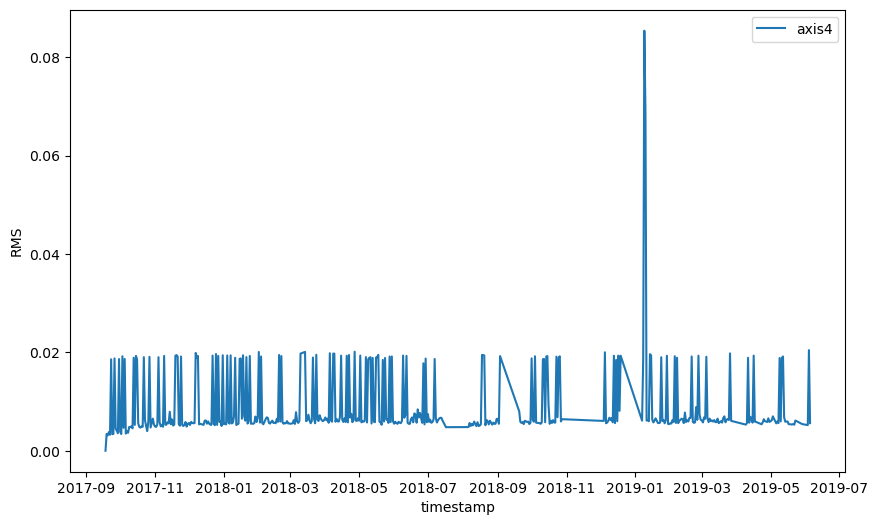

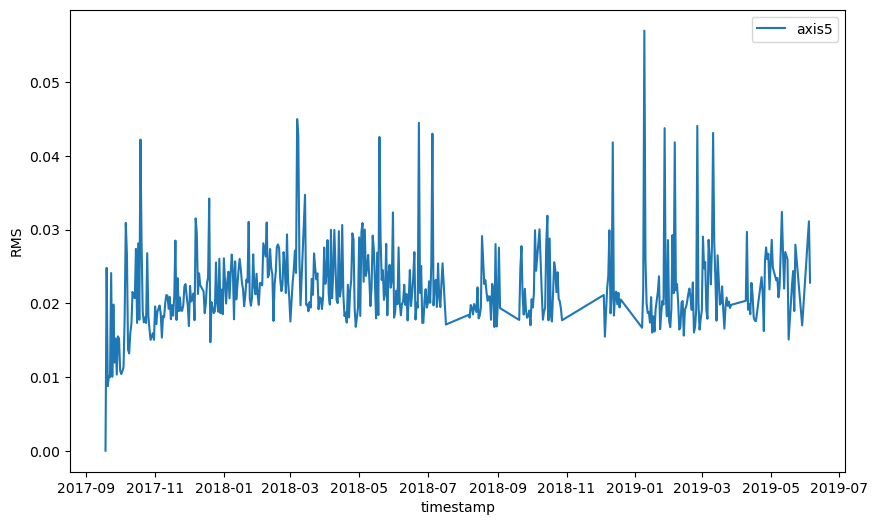

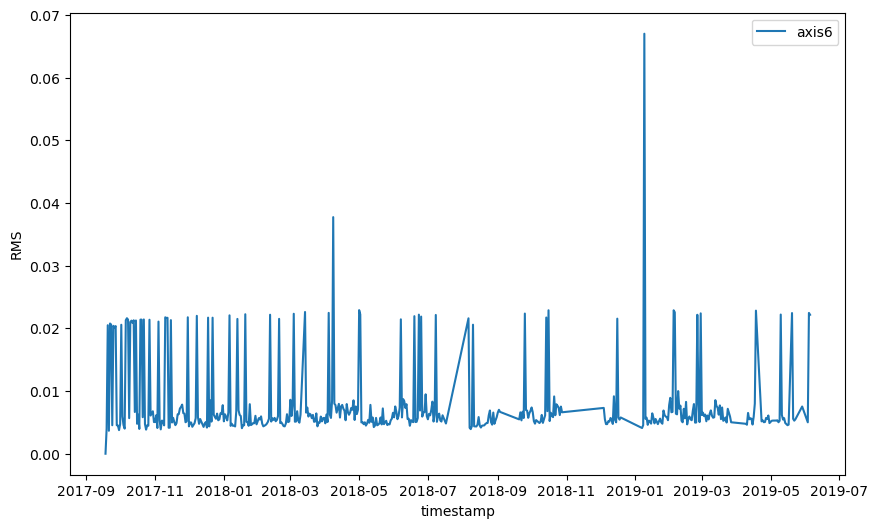

In [13]:
for i in columns:
    RMS_Value.plot(y=i, figsize=(10,6),xlabel='timestamp', ylabel='RMS')

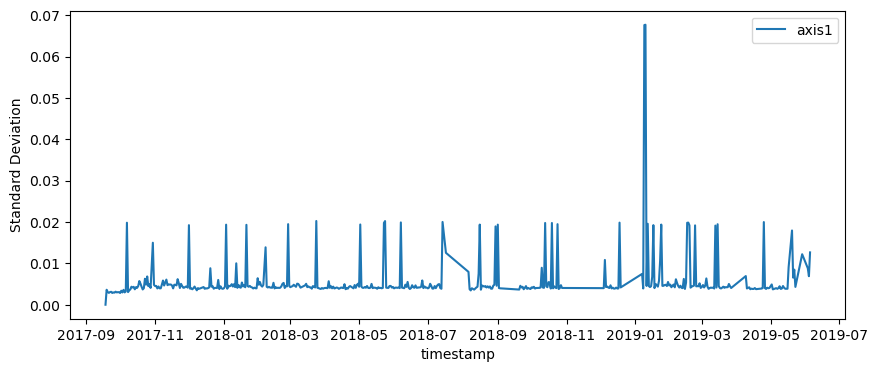

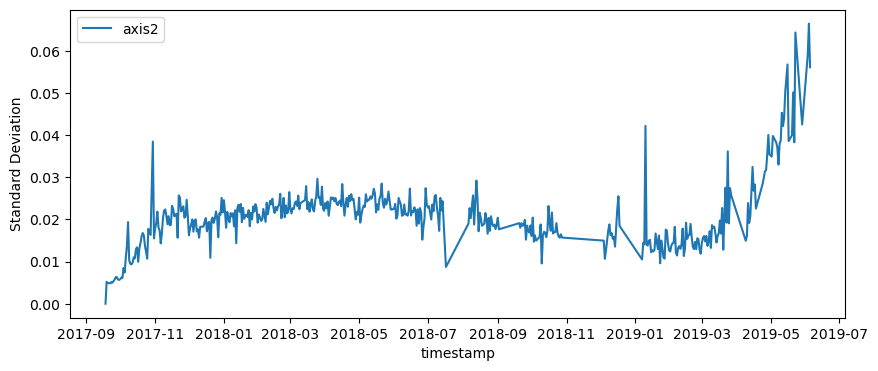

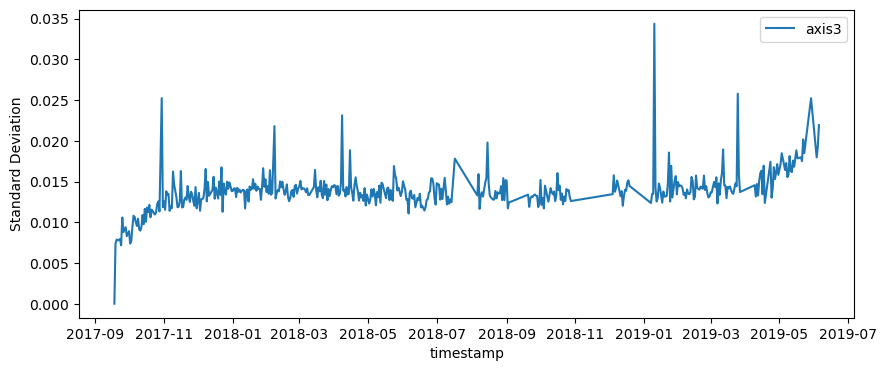

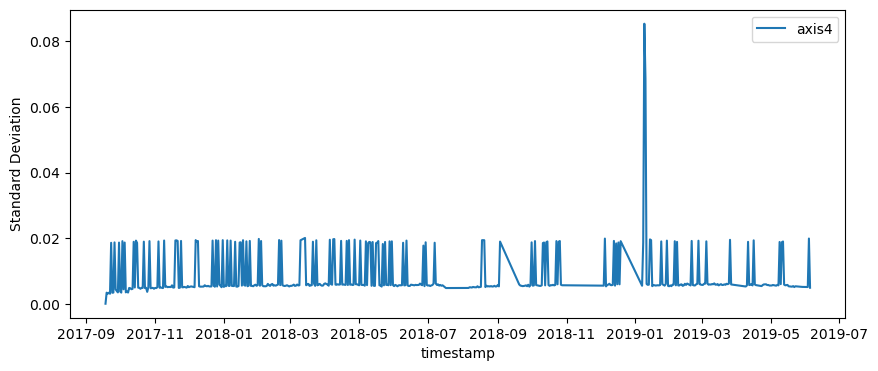

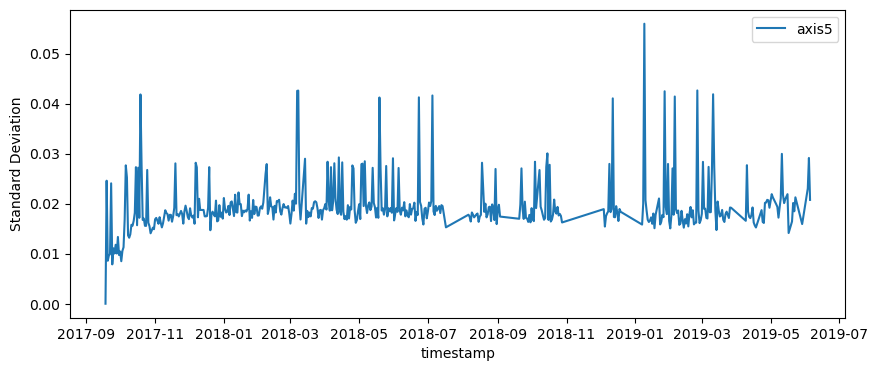

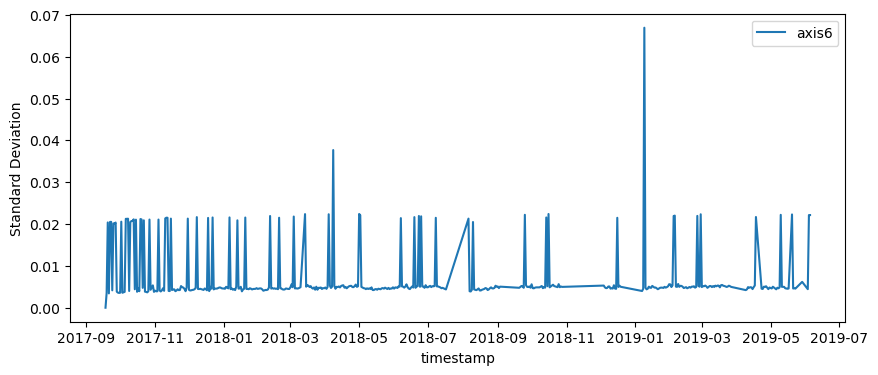

In [14]:
for i in columns:
    Stv.plot(y=i, figsize=(10,4),xlabel='timestamp', ylabel='Standard Deviation')

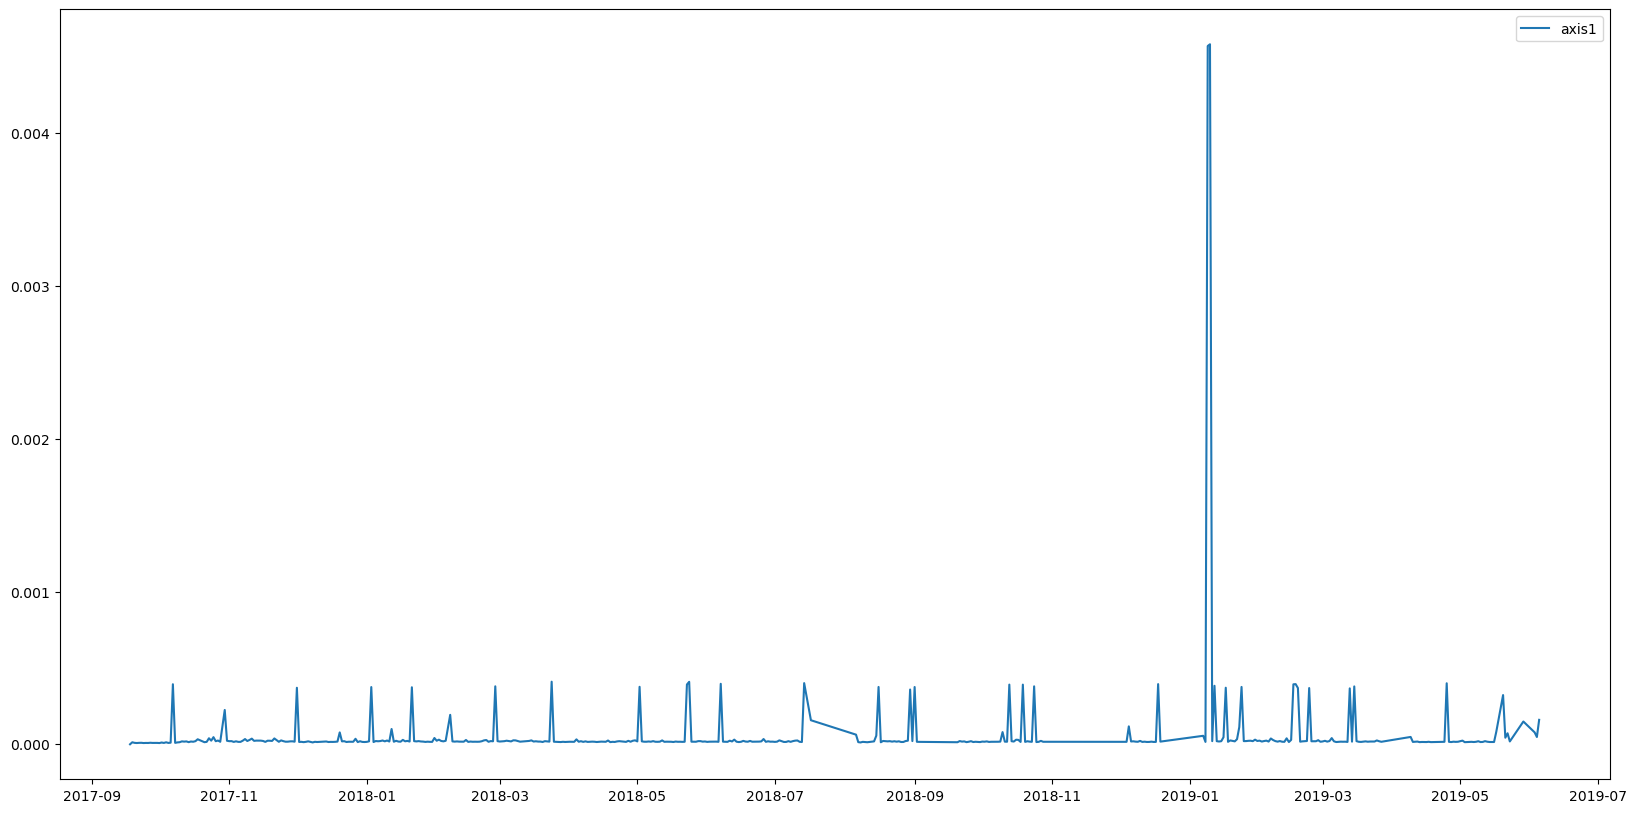

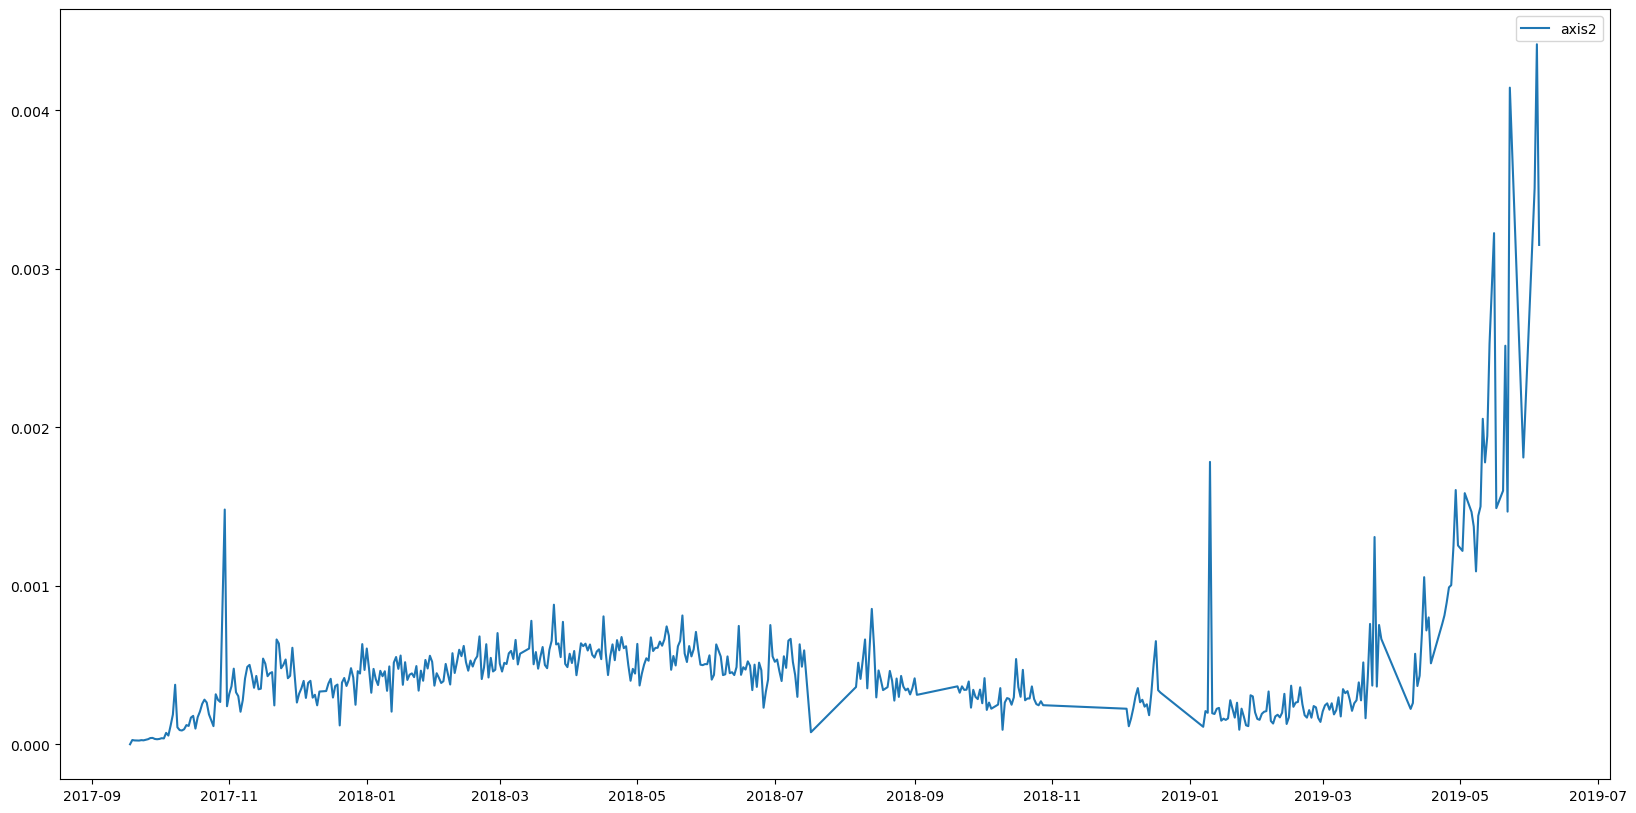

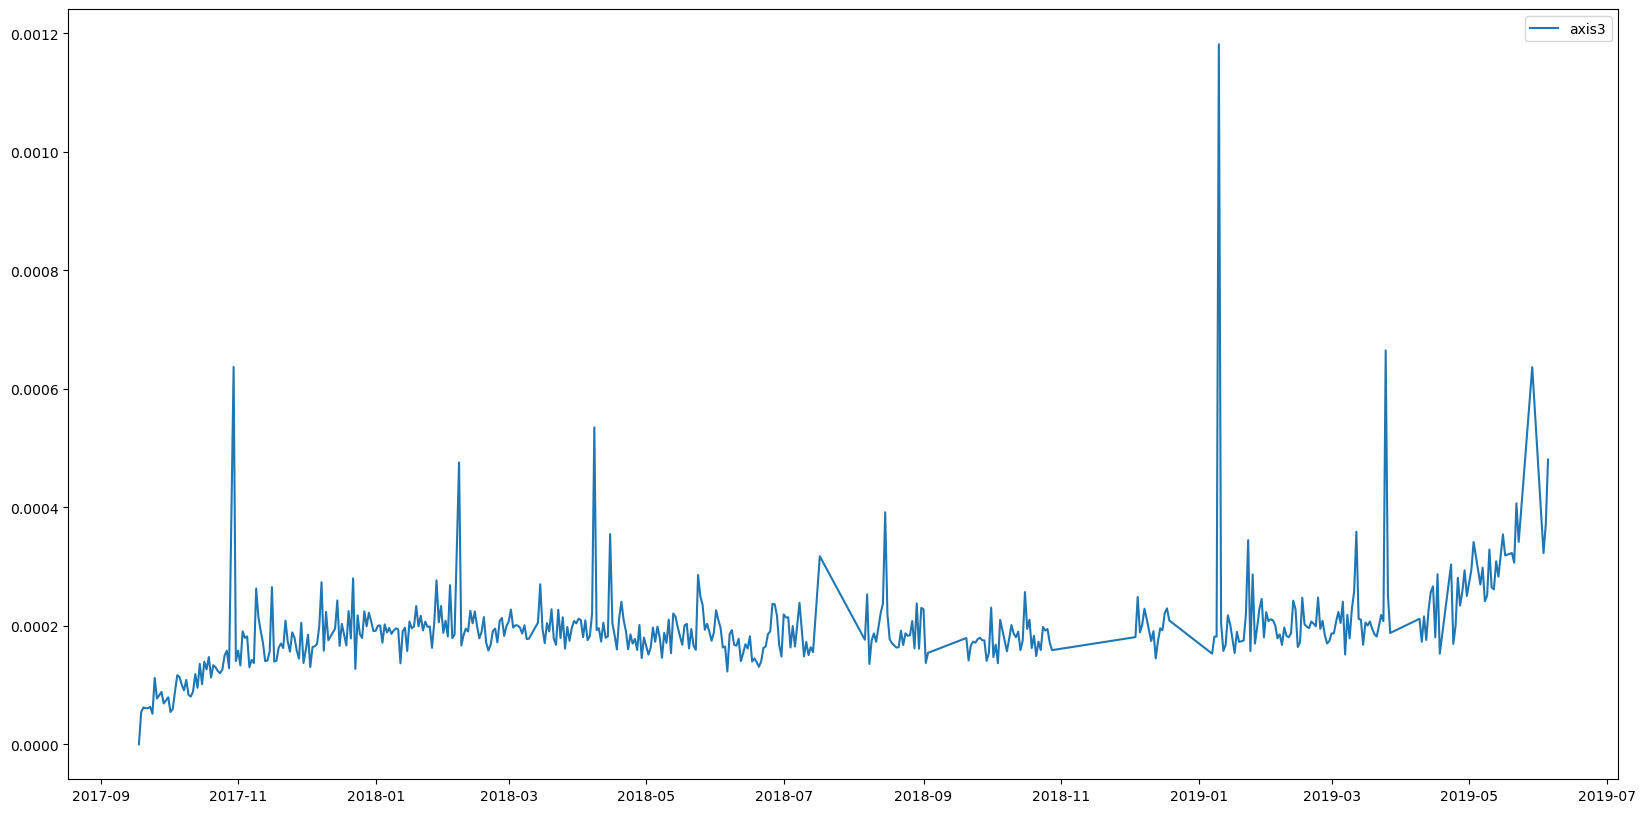

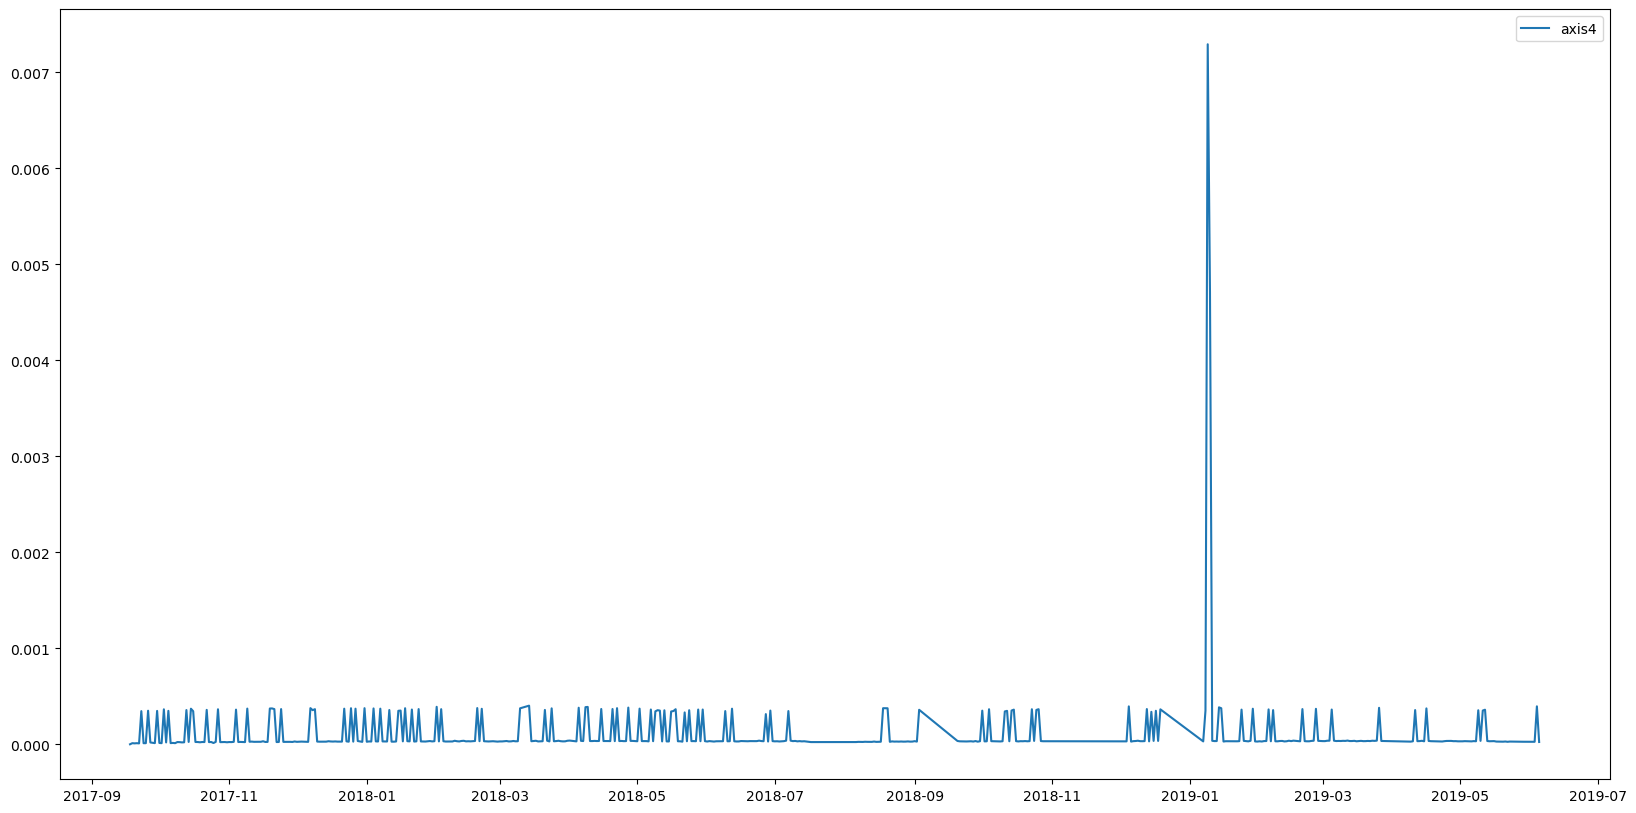

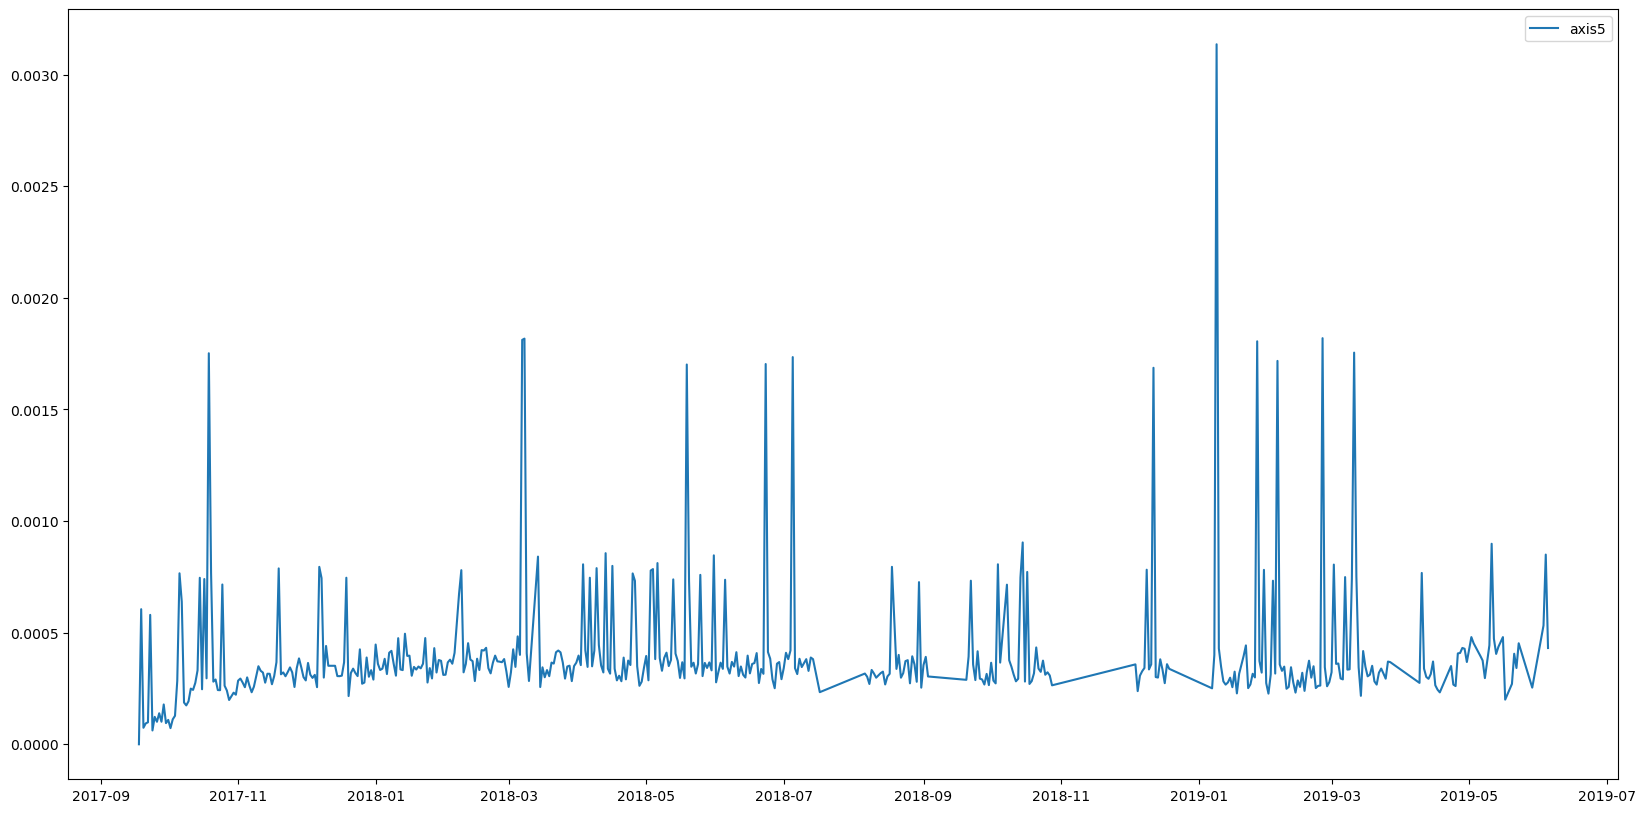

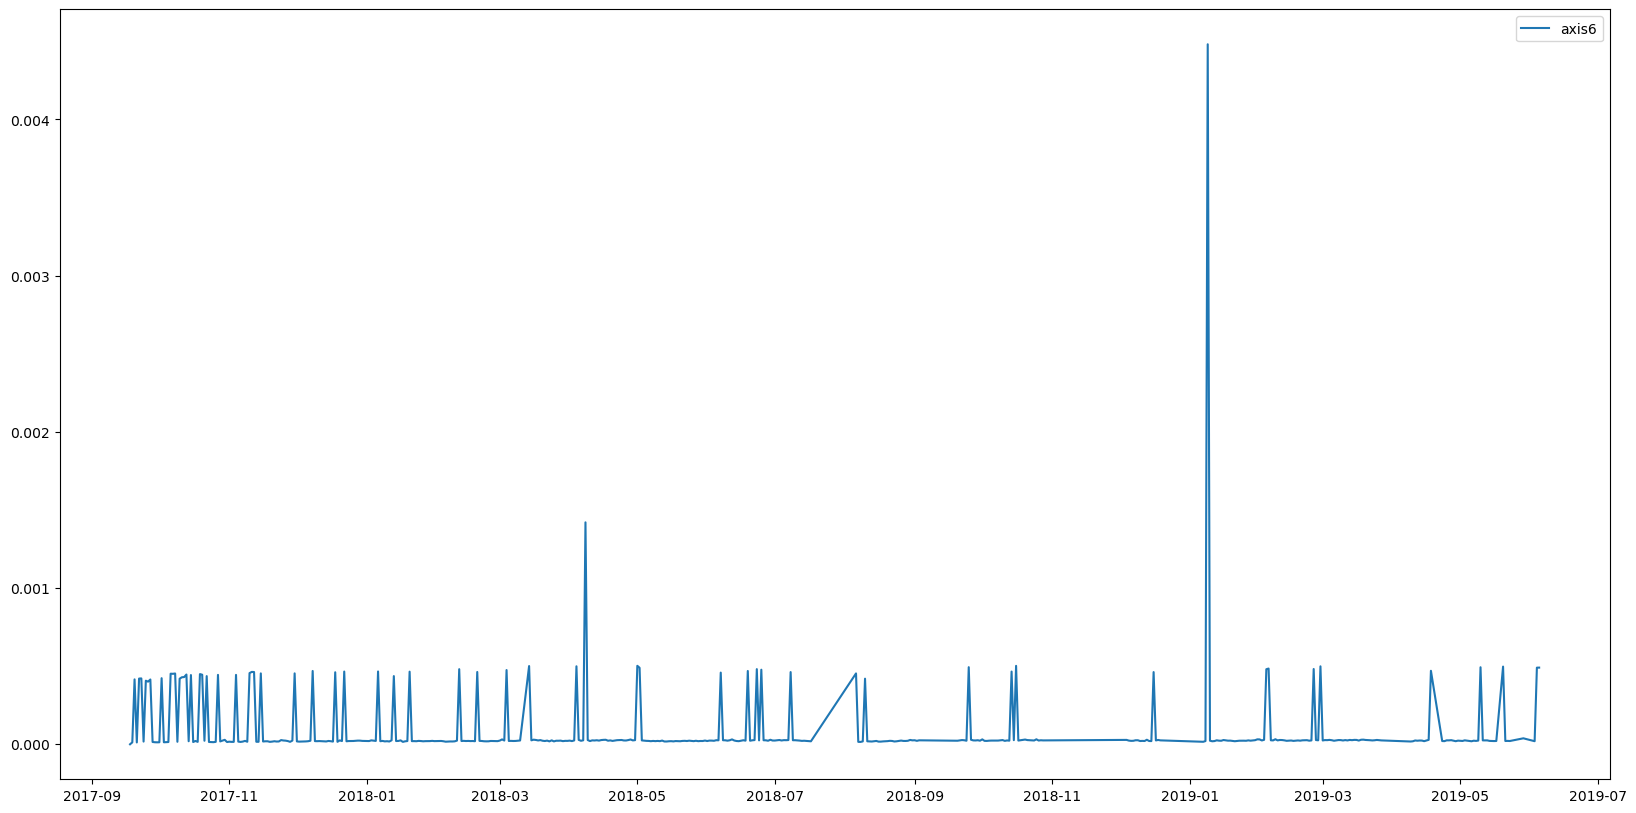

In [15]:
for i in columns:
    Variance.plot(y=i, figsize=(20,10))


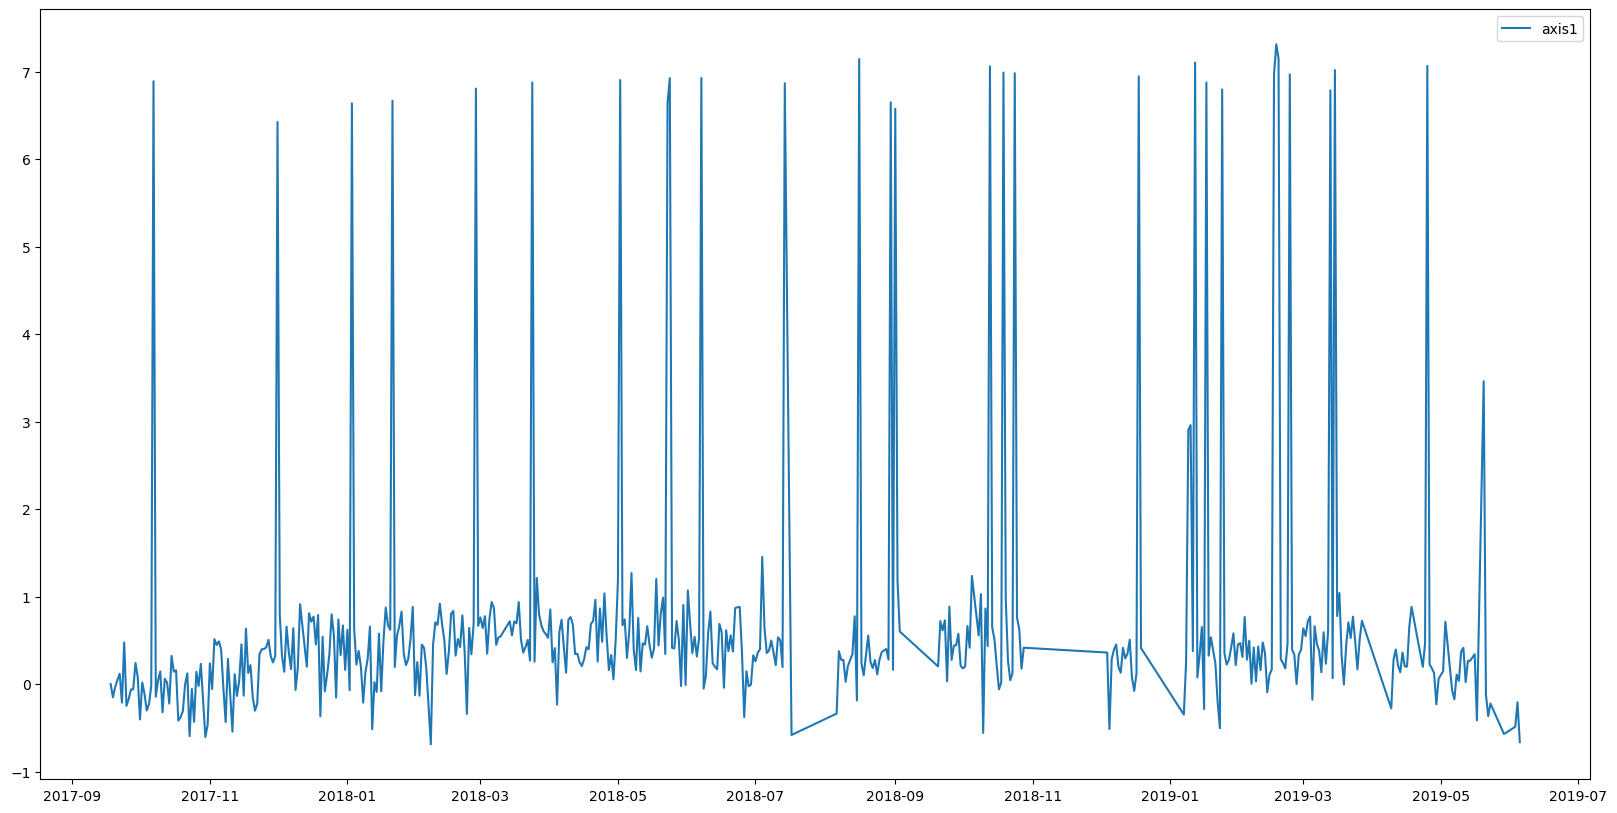

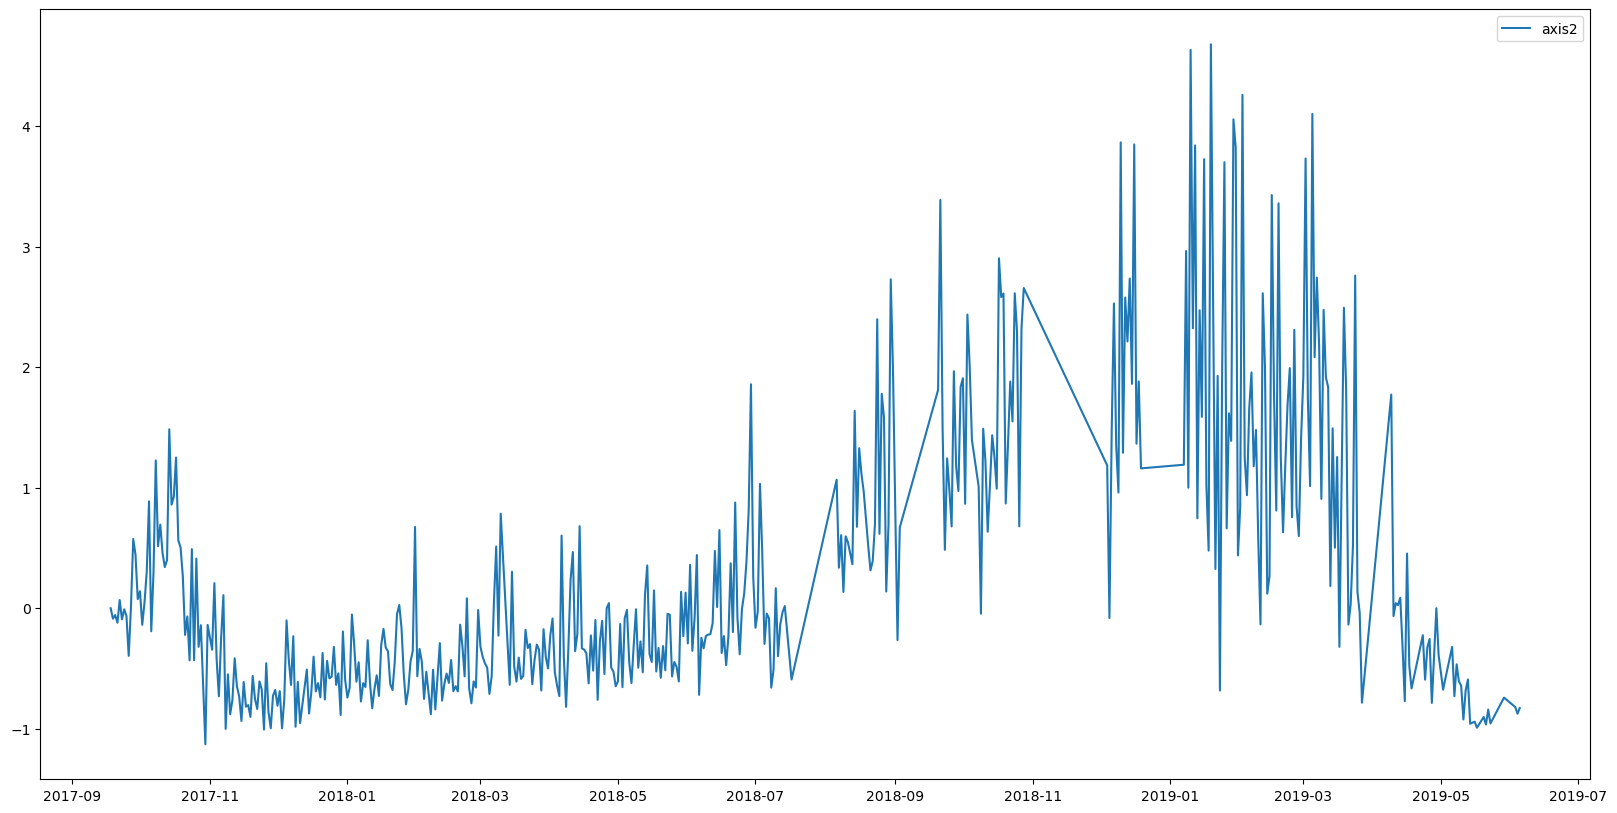

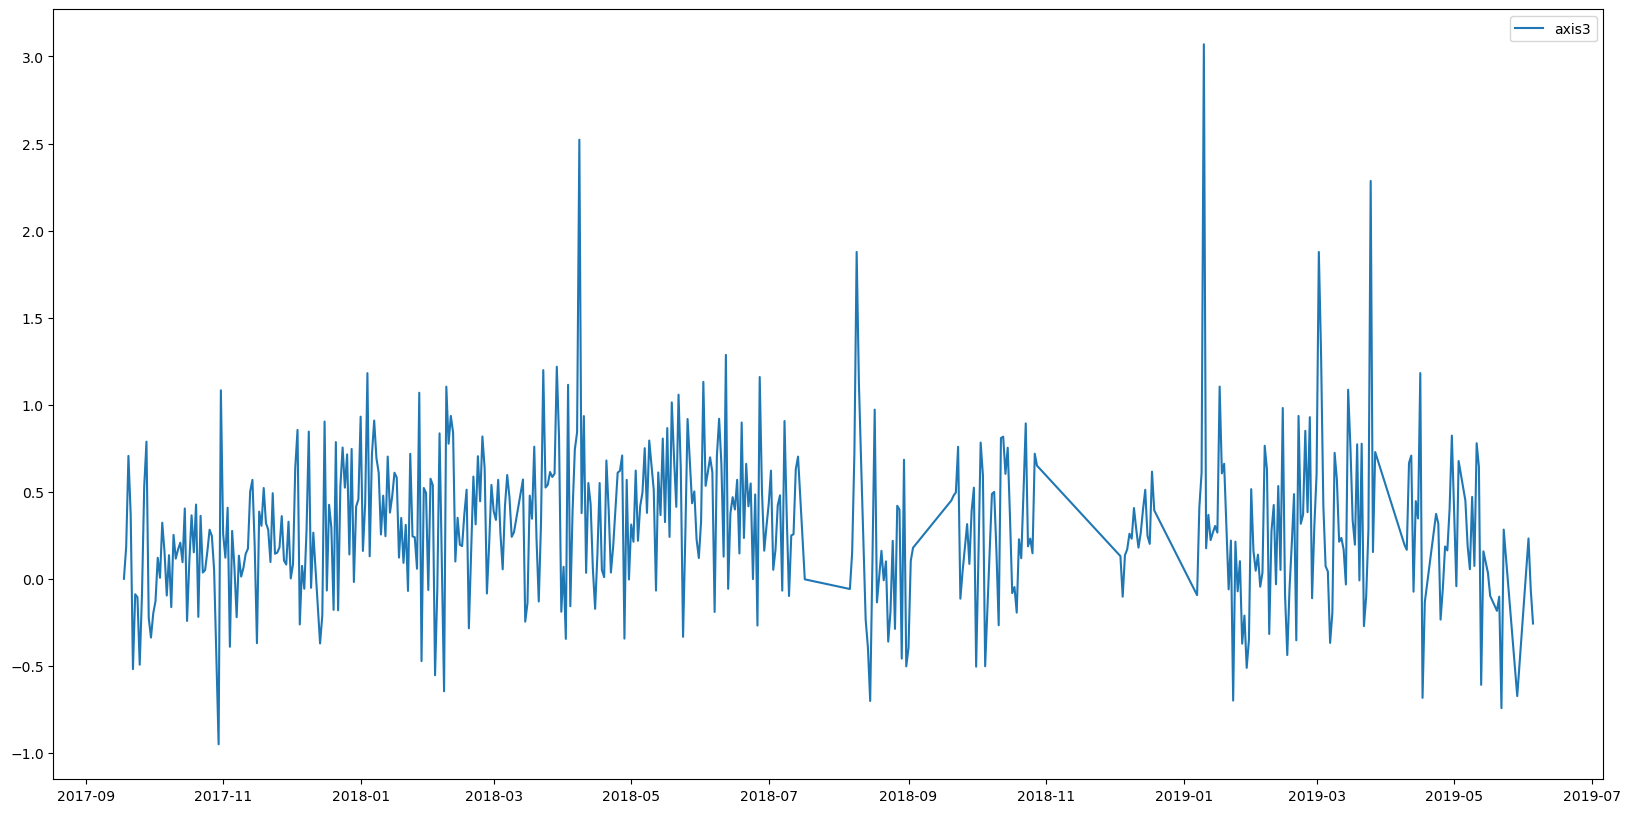

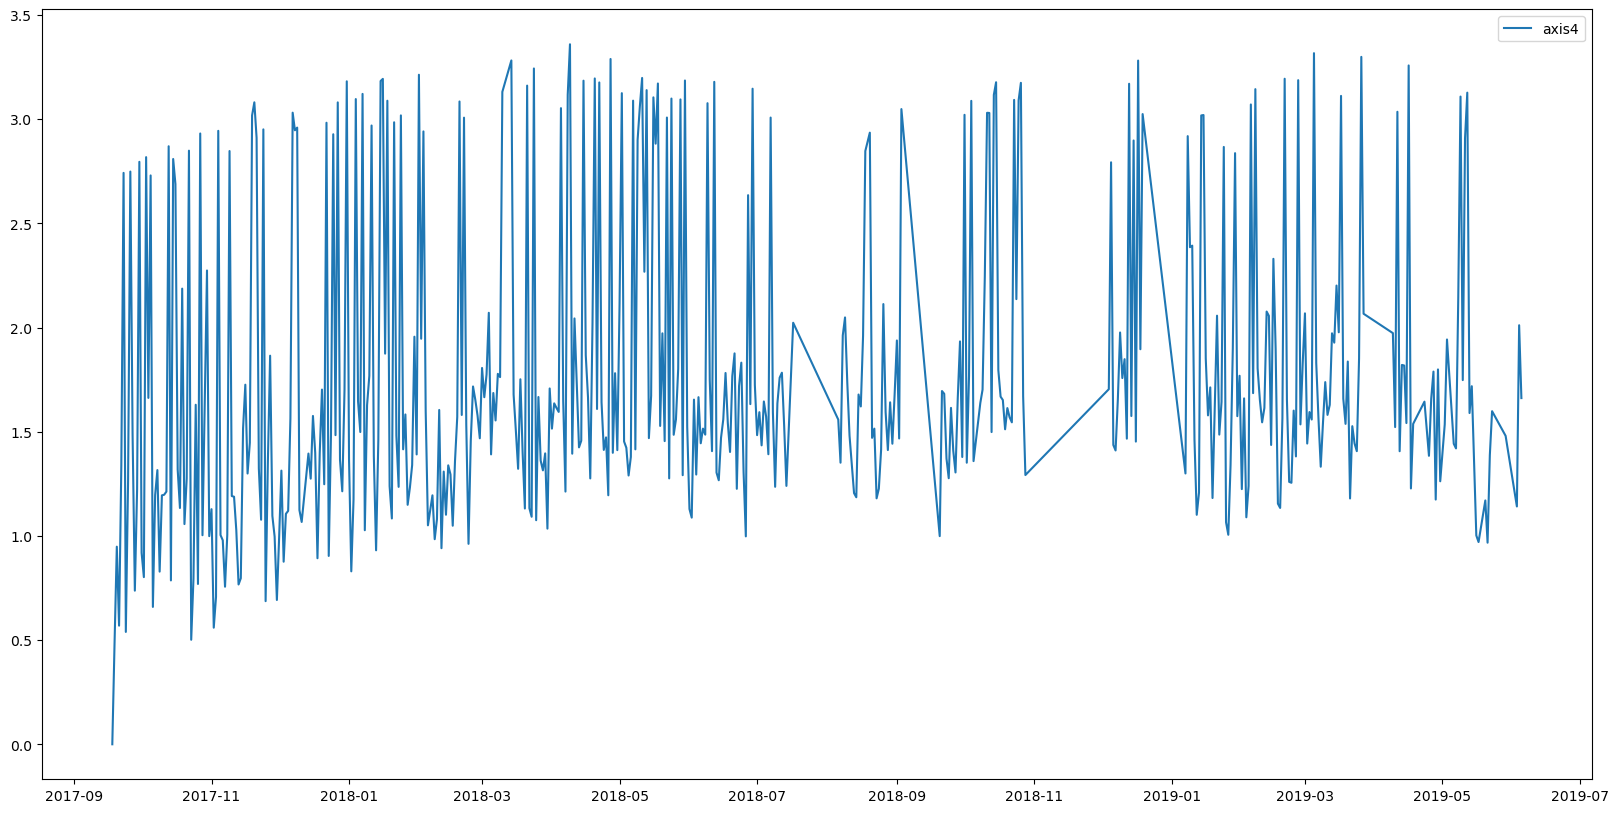

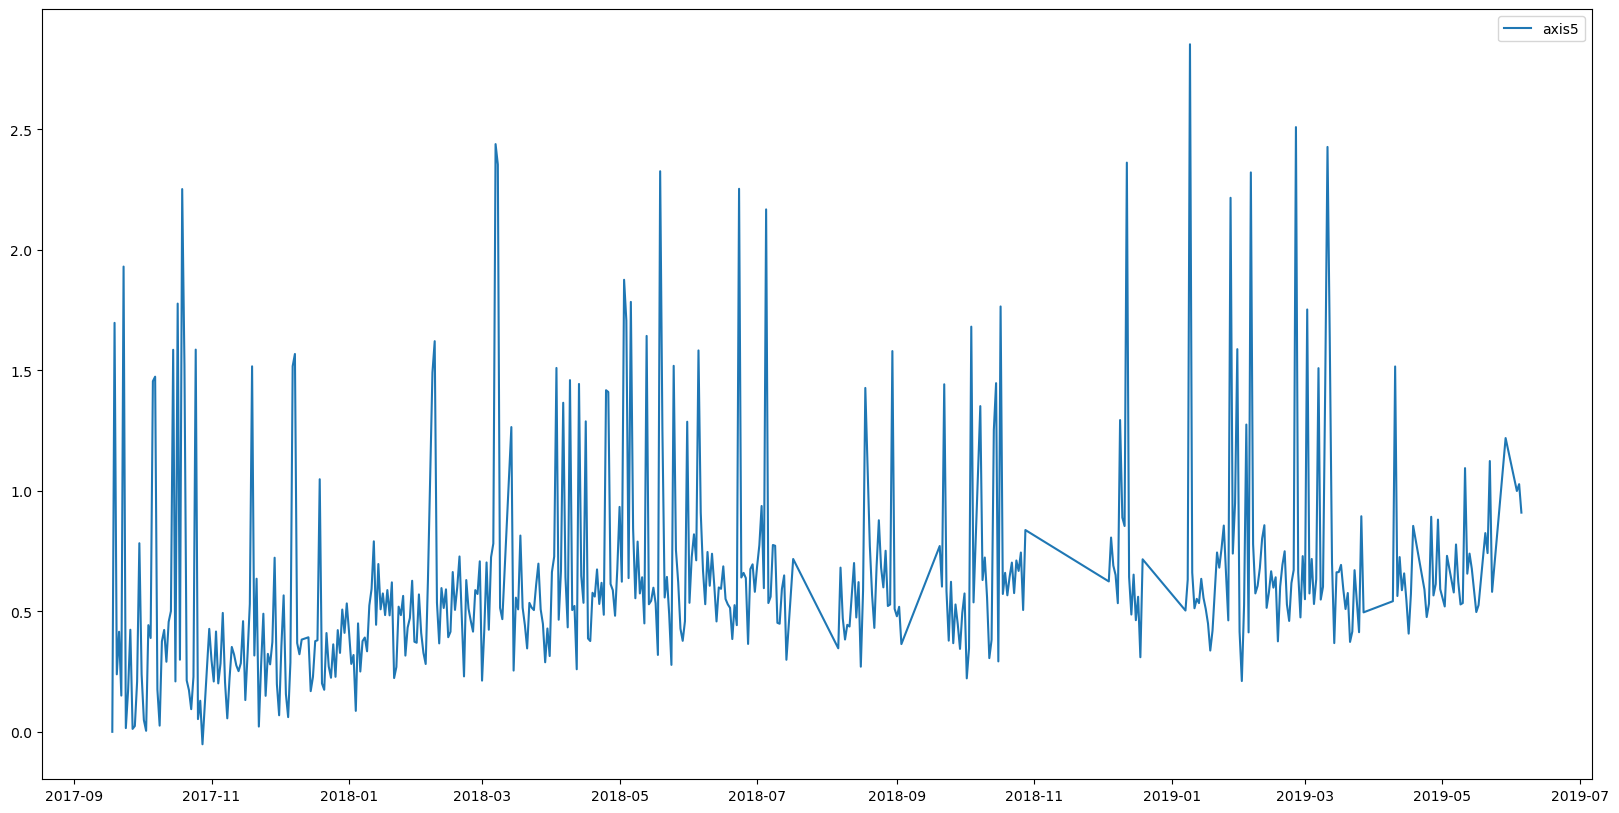

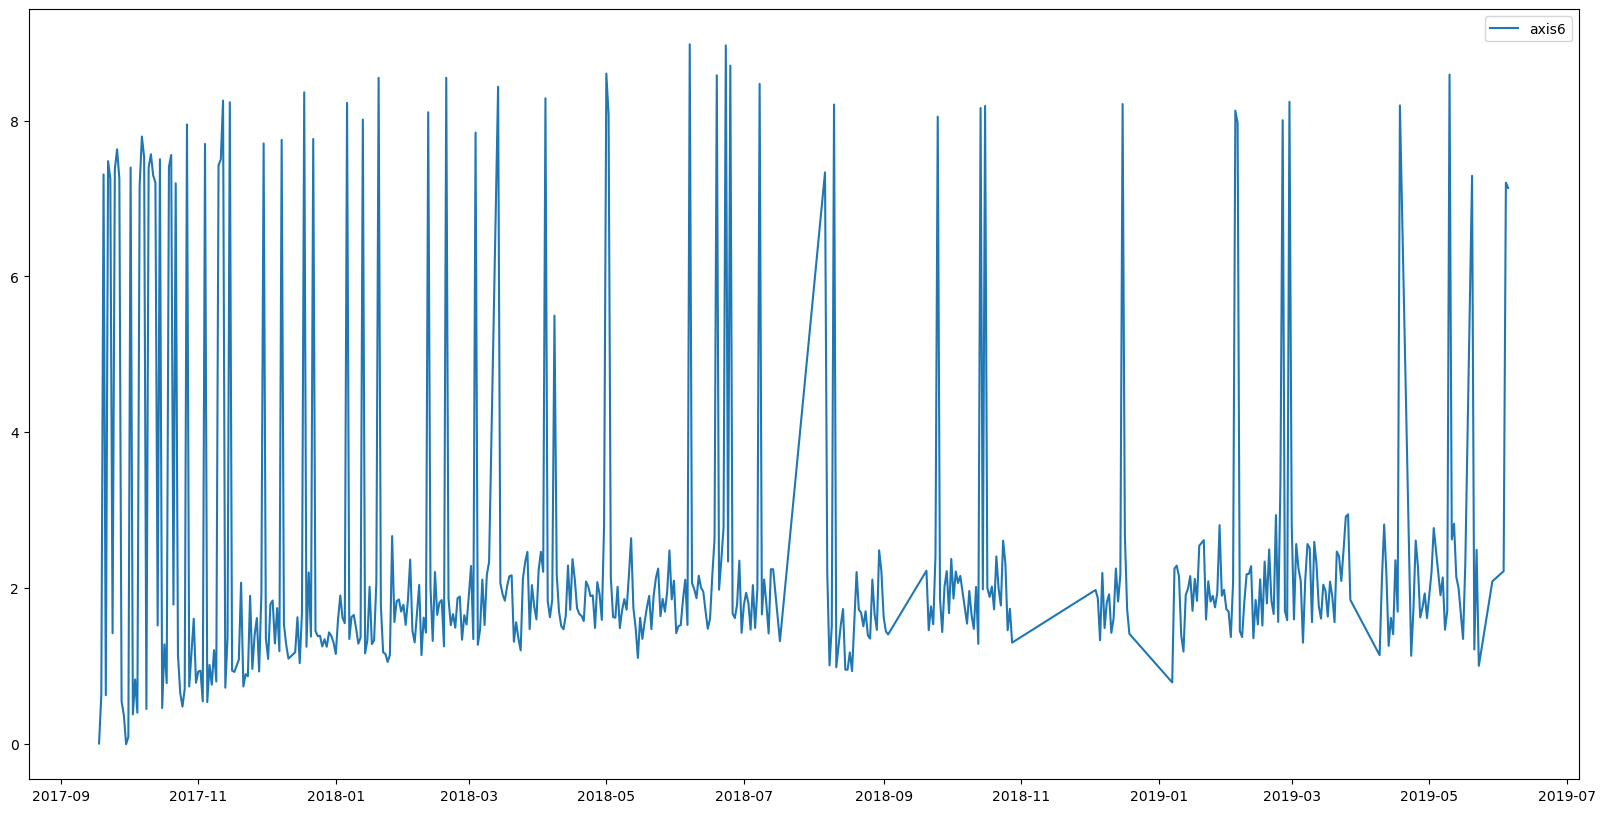

In [16]:
for i in columns:
    Kurtosis_value.plot(y=i, figsize=(20,10))

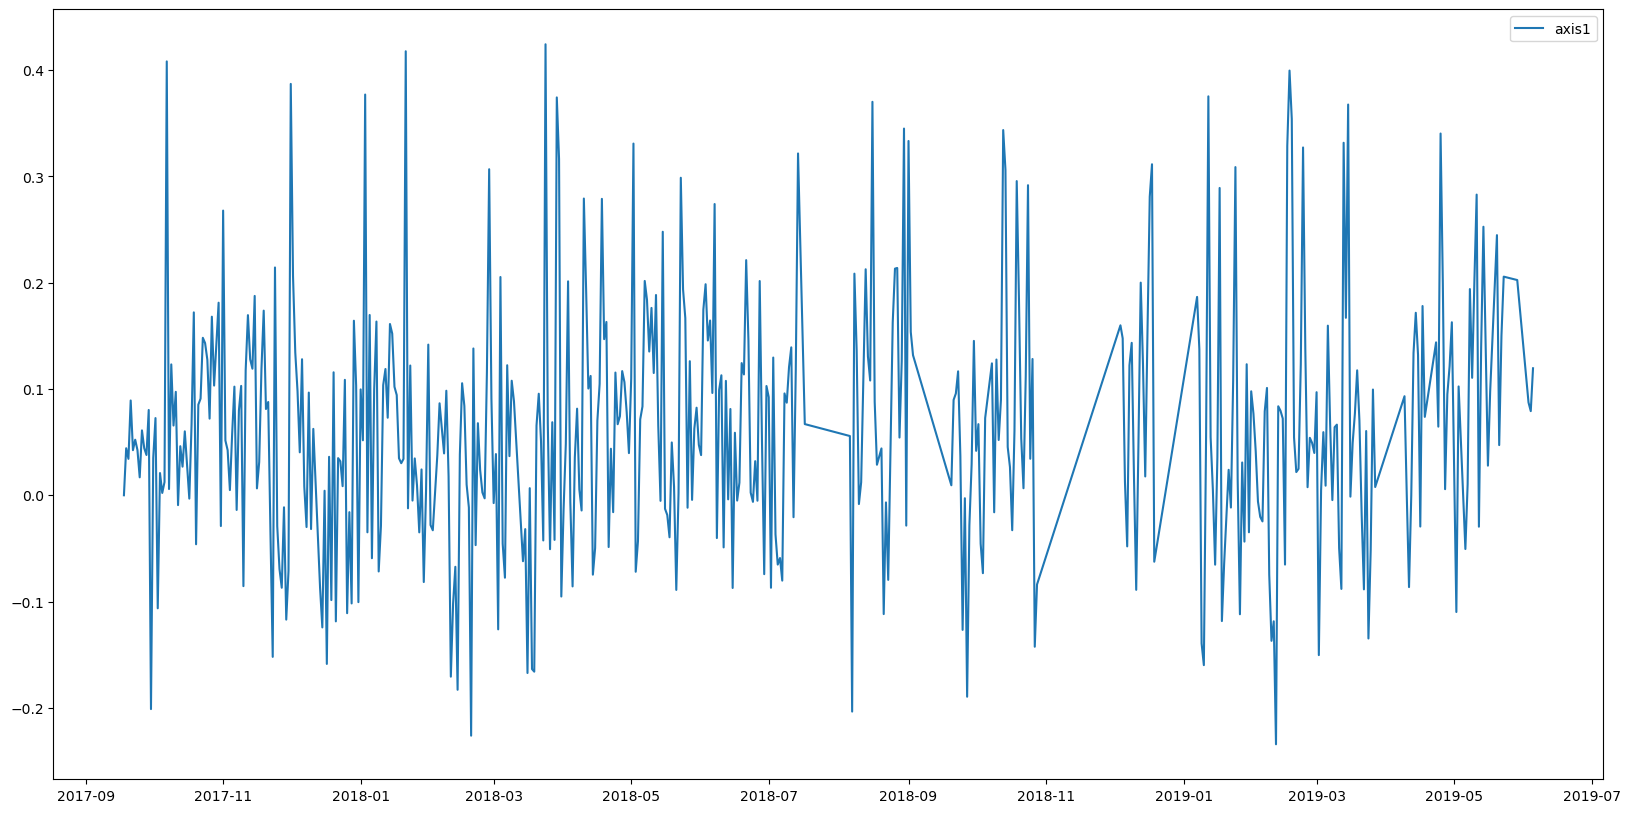

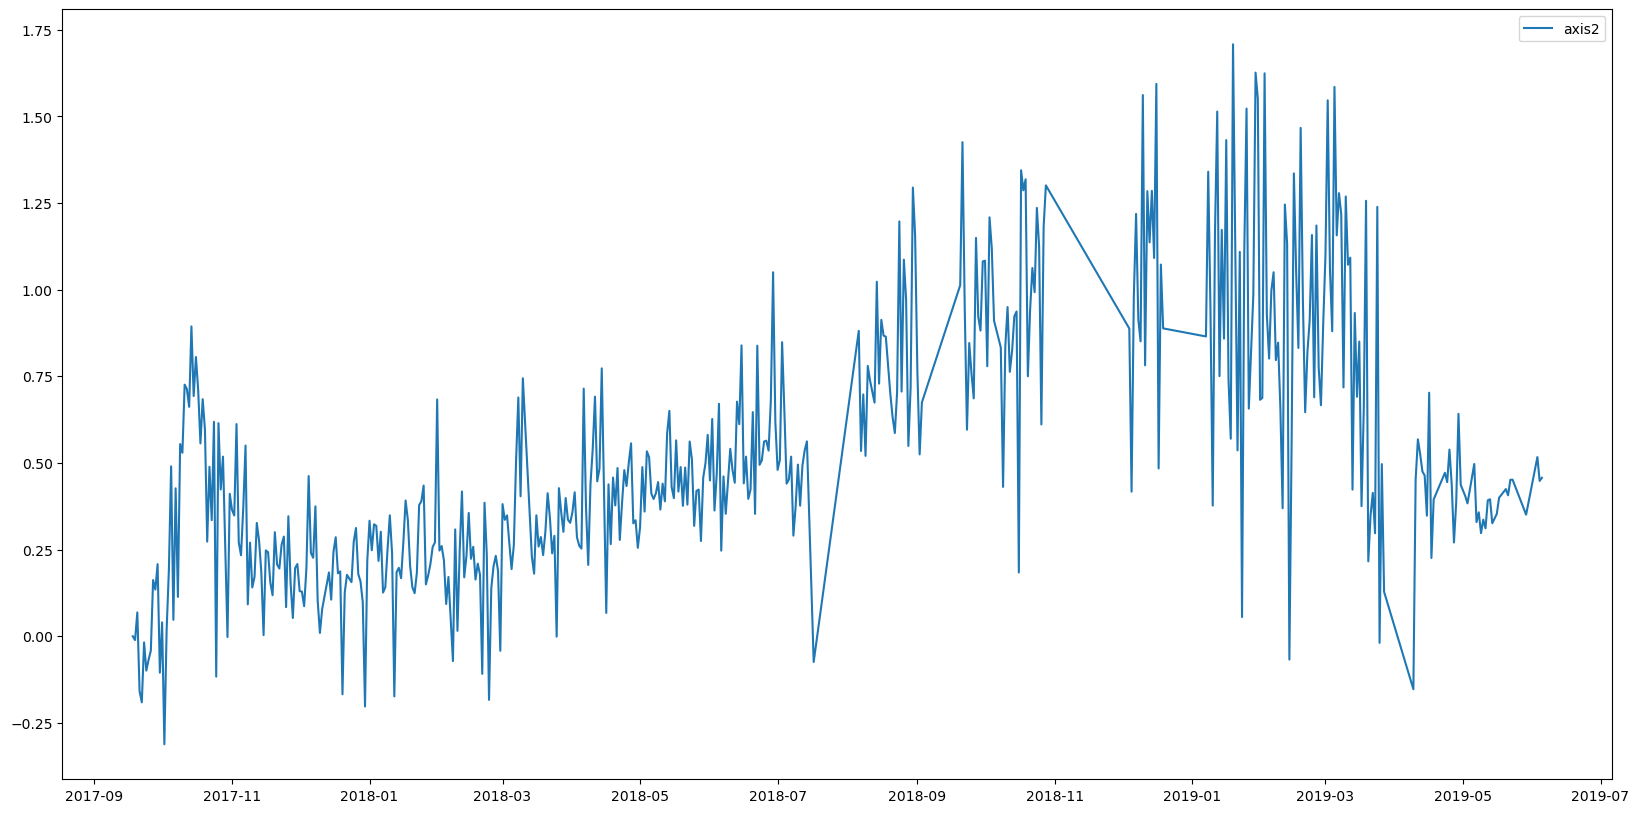

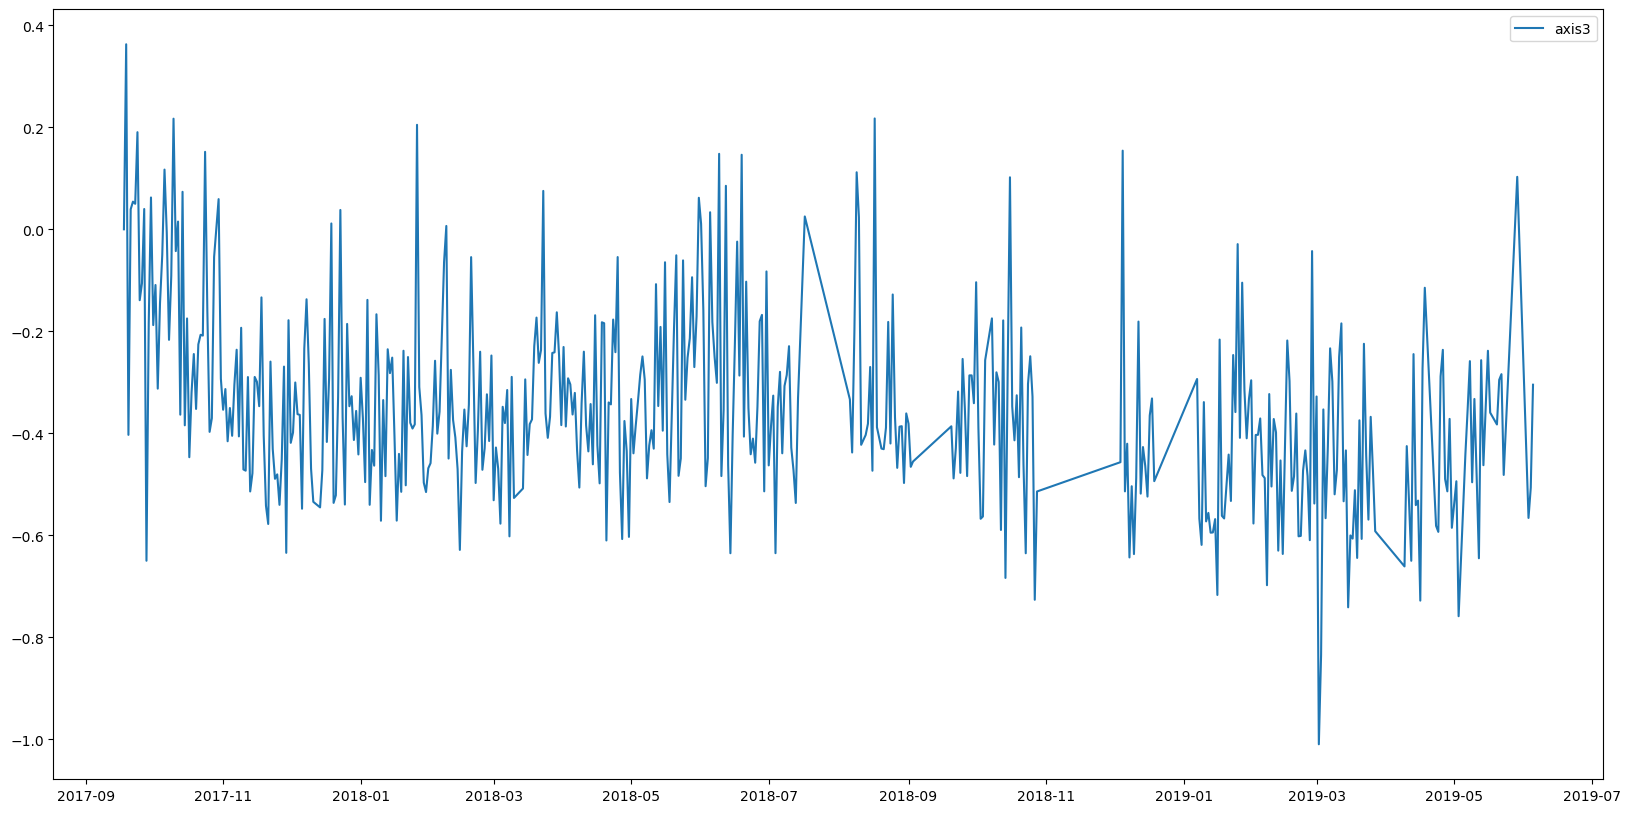

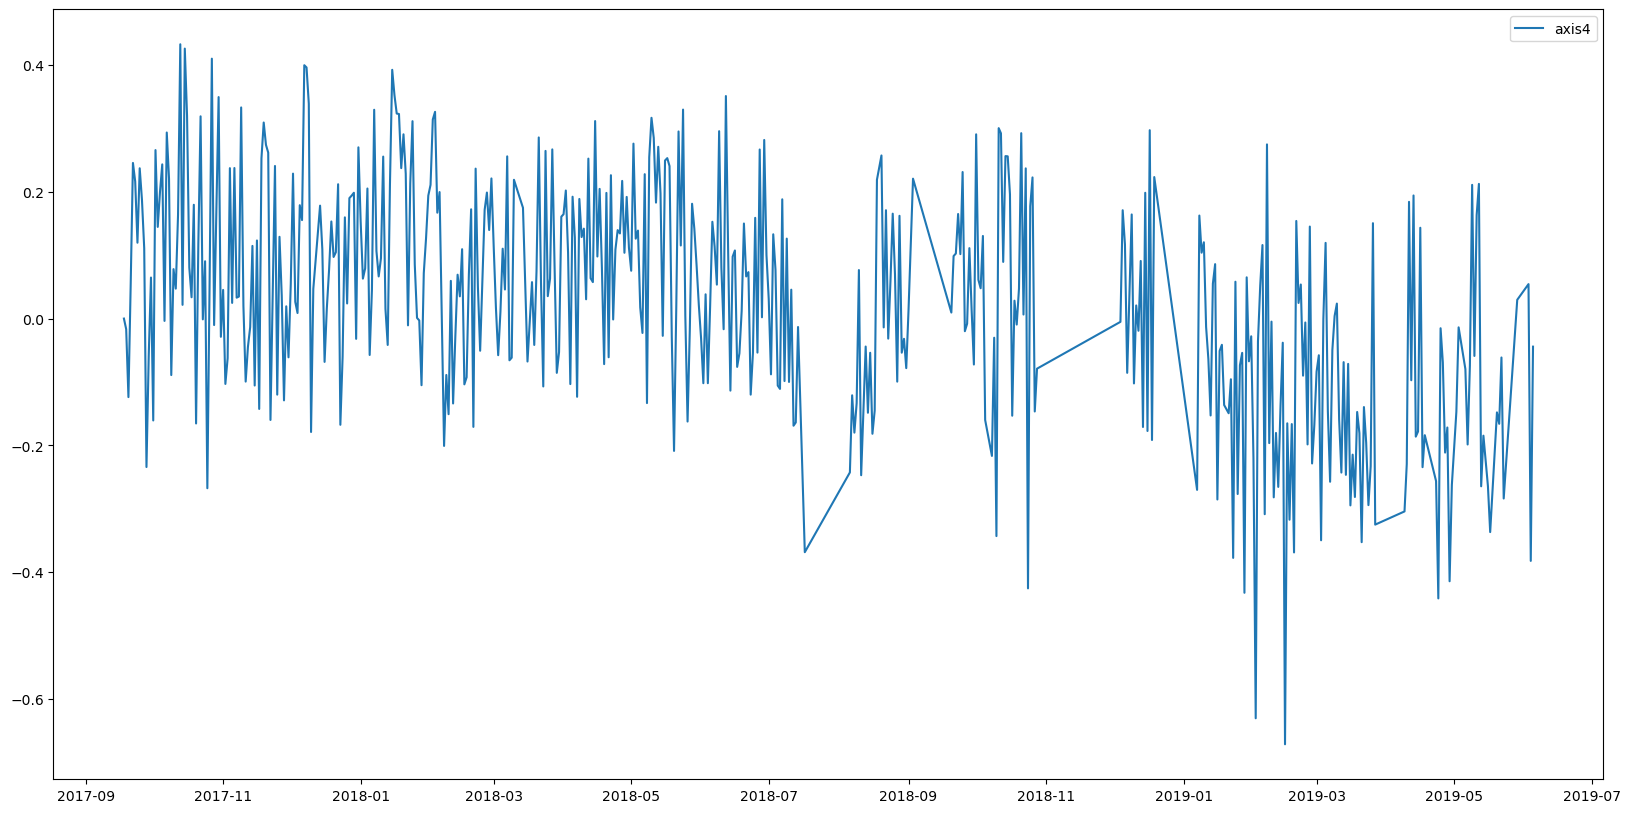

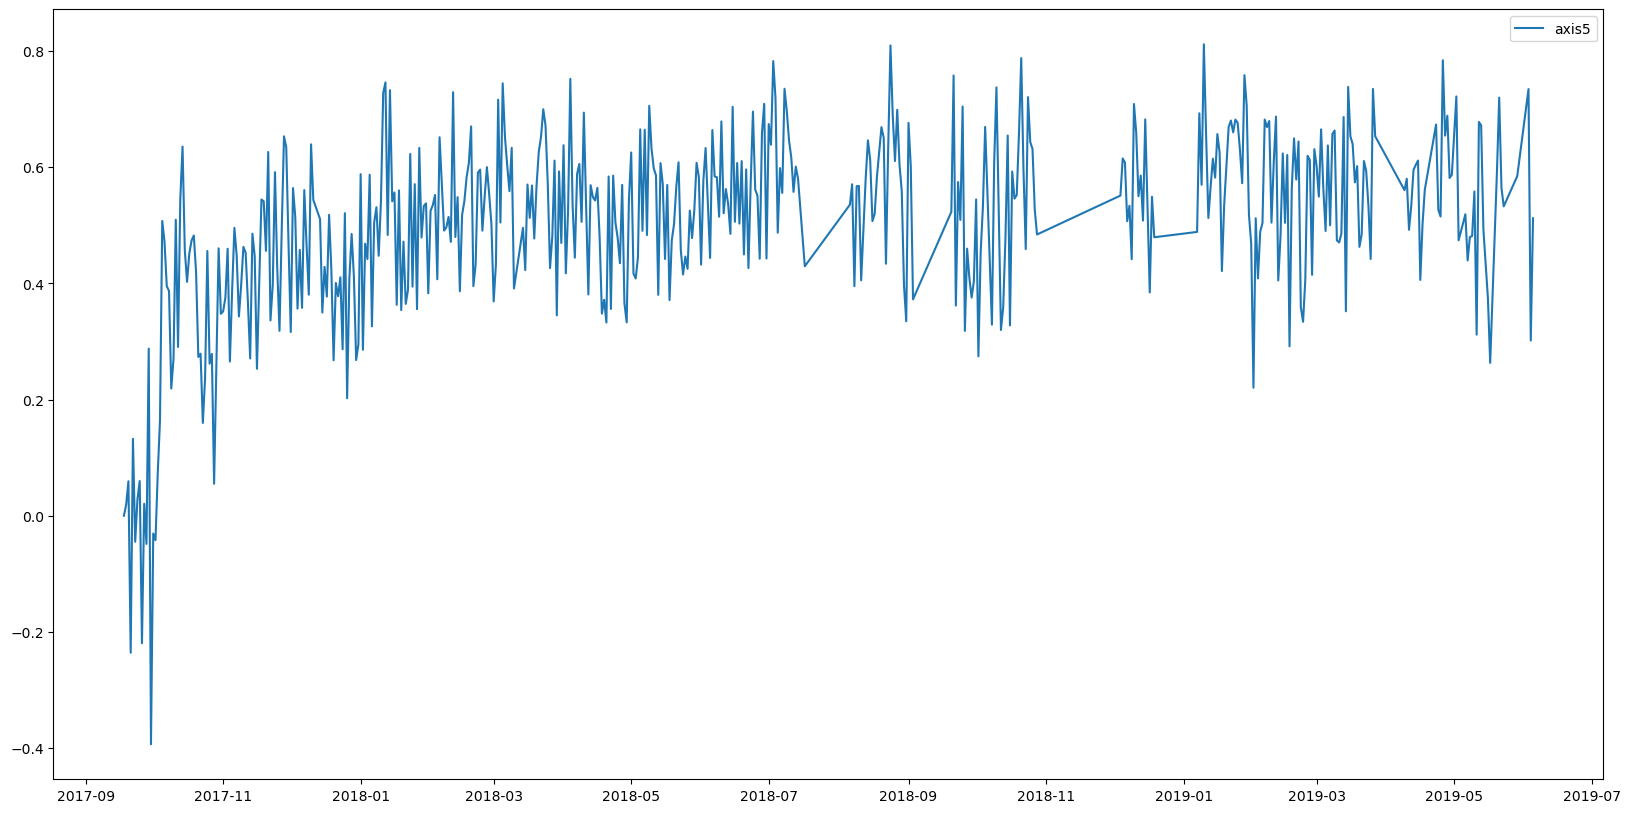

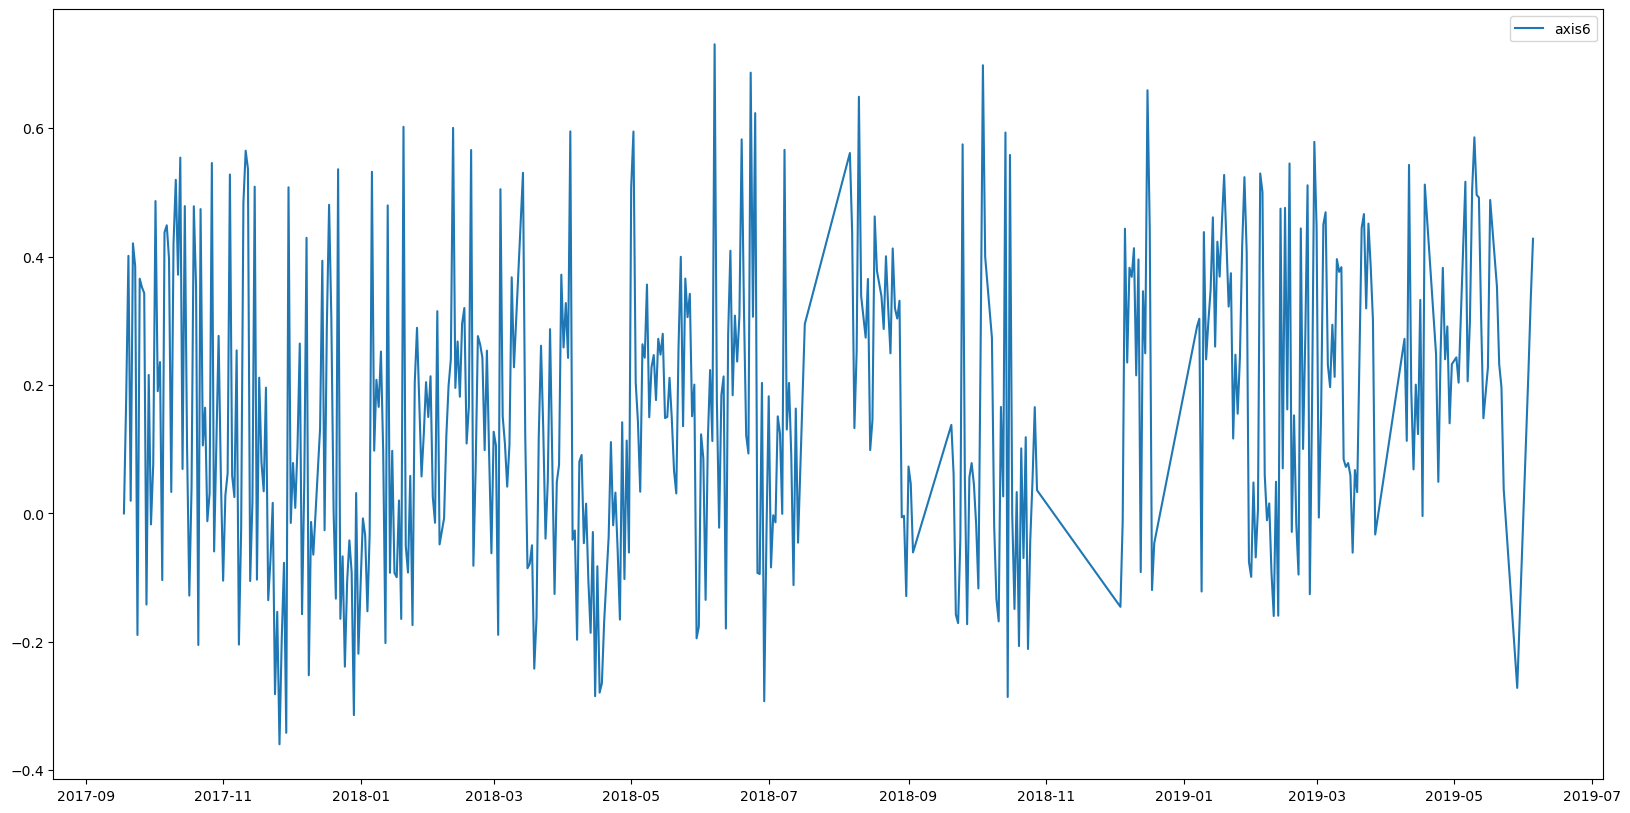

In [17]:
for i in columns:
    Skewness_value.plot(y=i, figsize=(20,10))


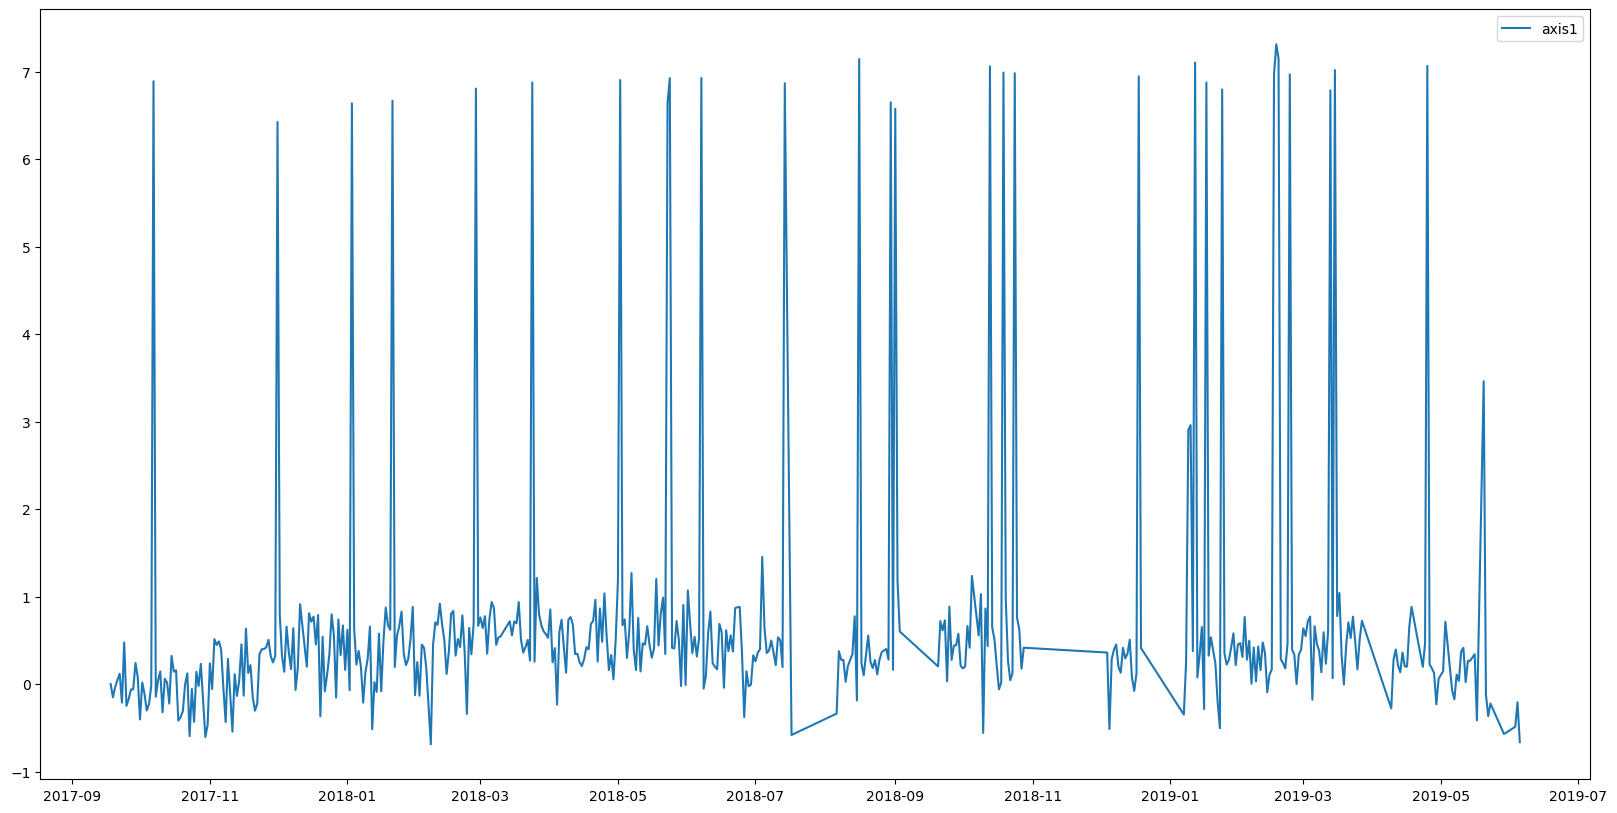

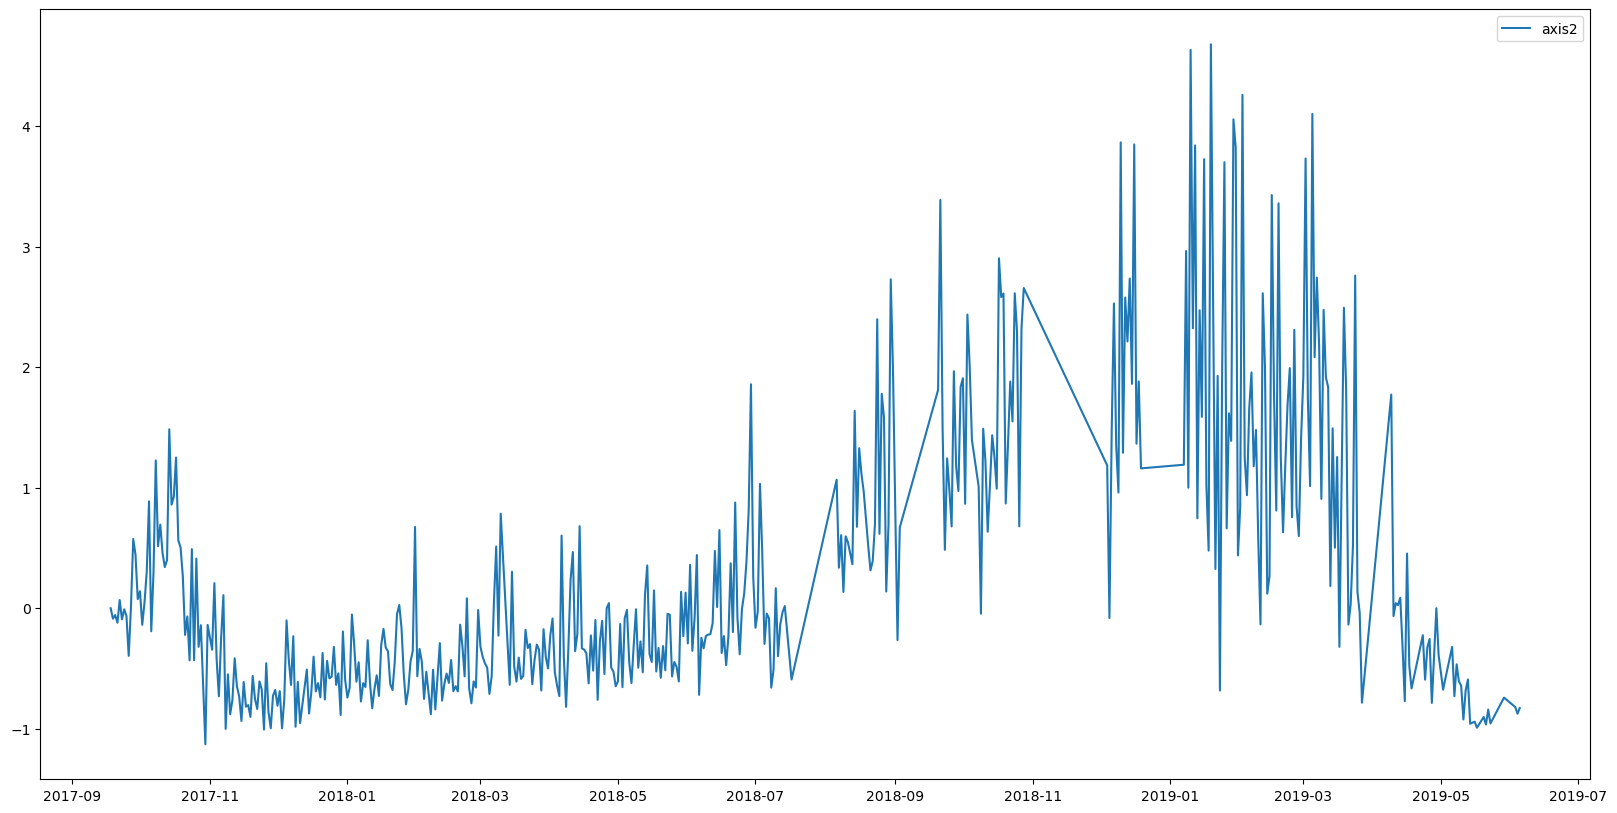

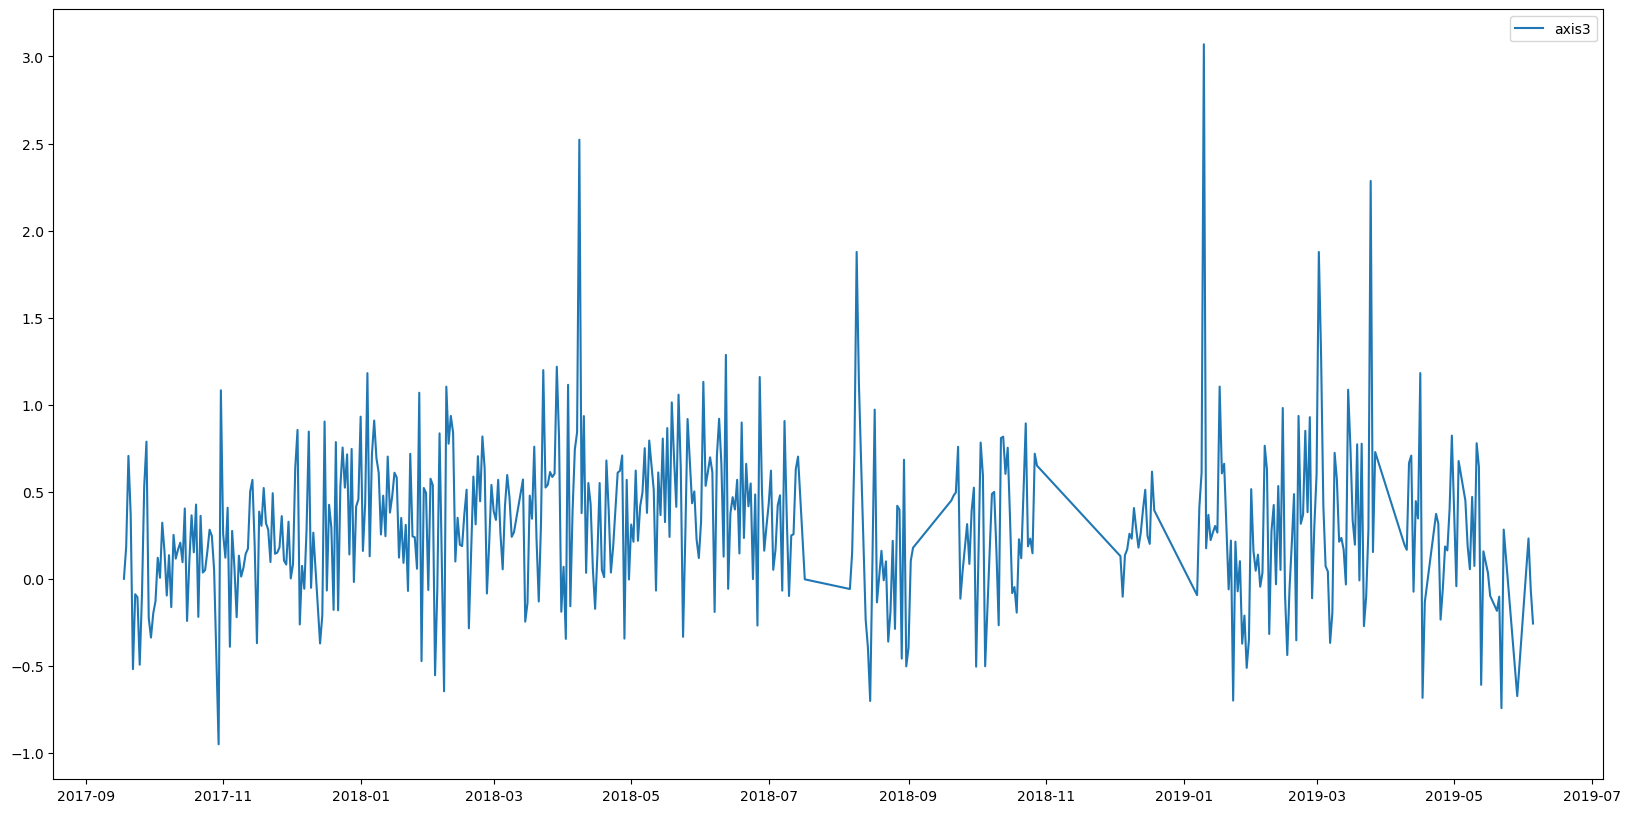

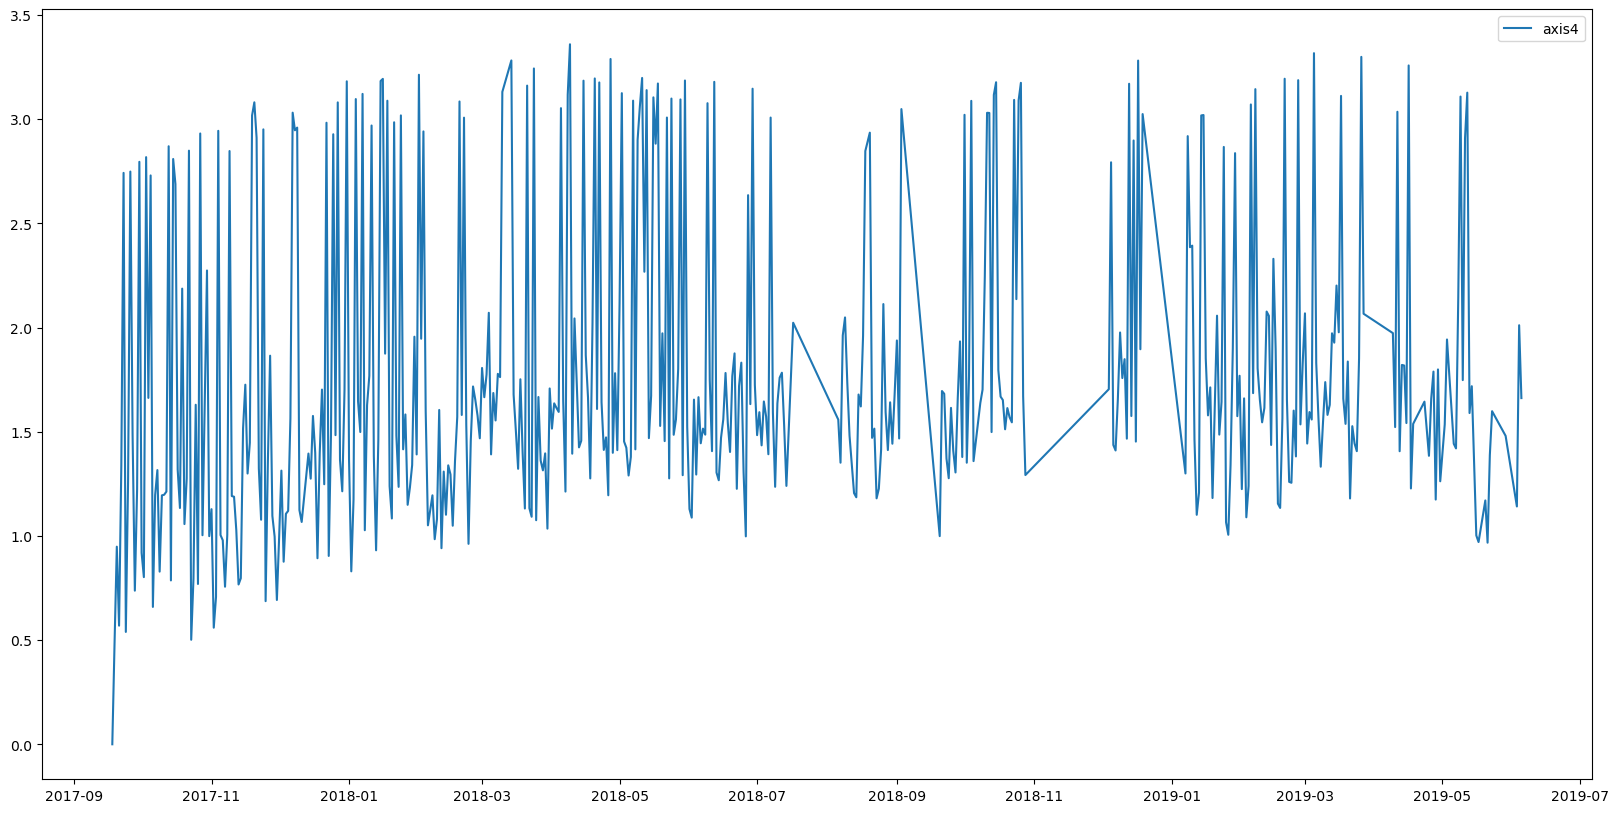

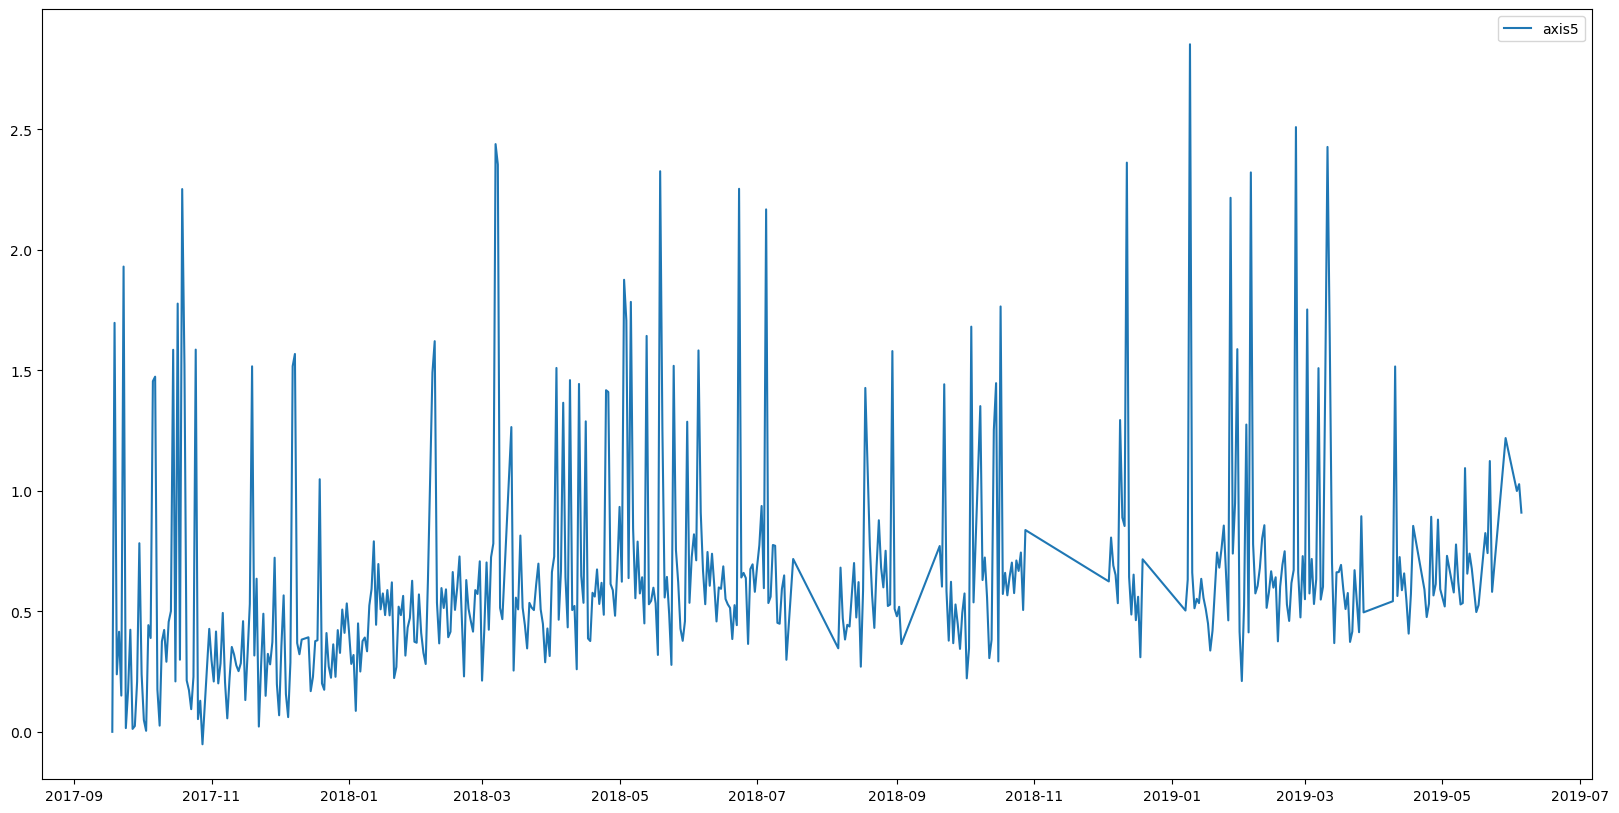

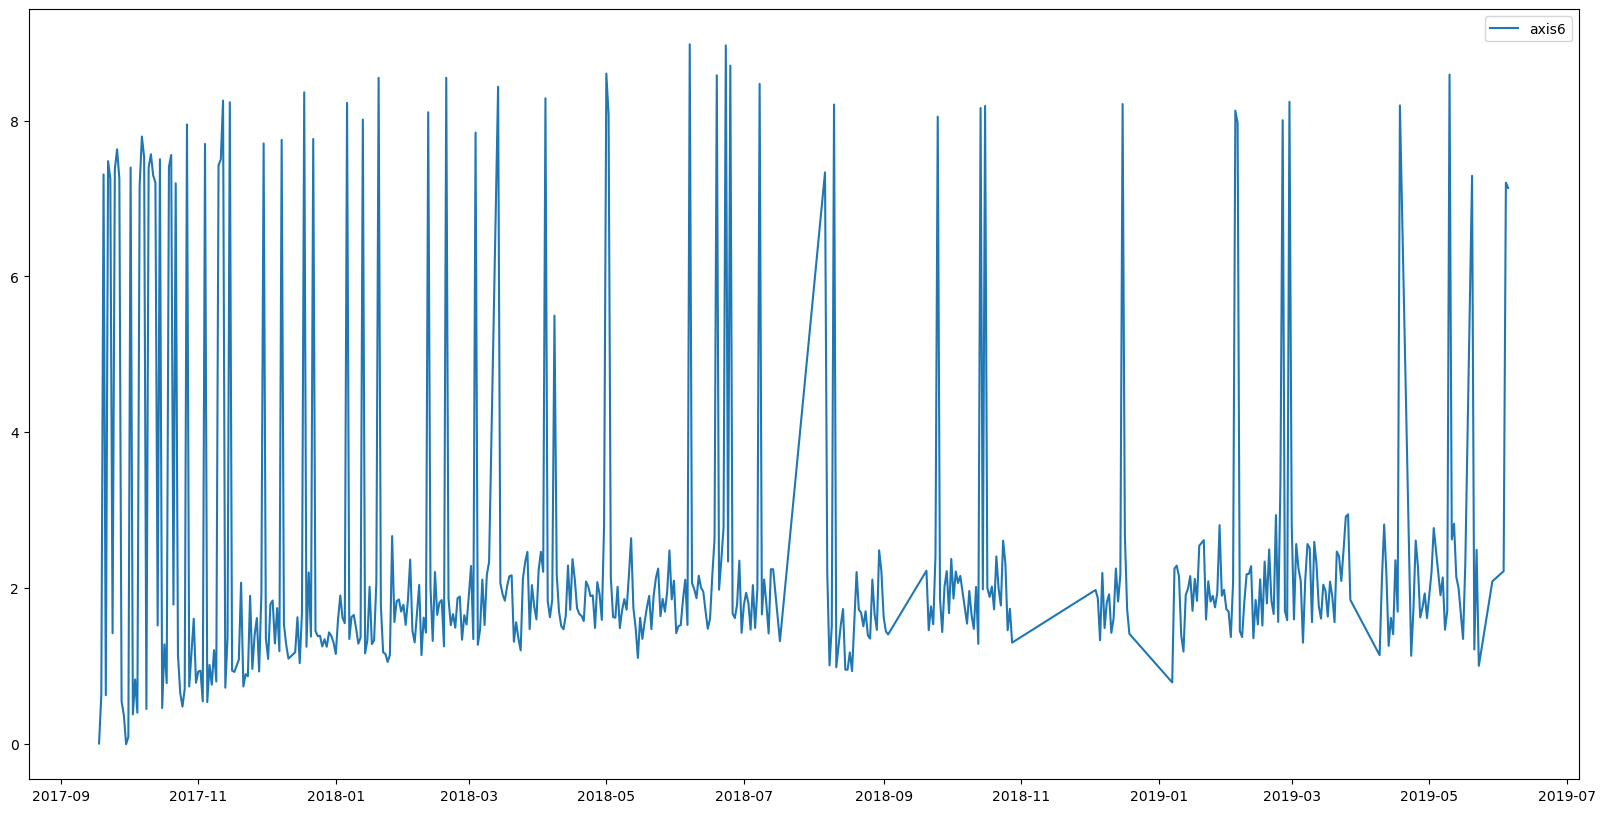

In [18]:
for i in columns:
    Kurtosis_value.plot(y=i, figsize=(20,10))

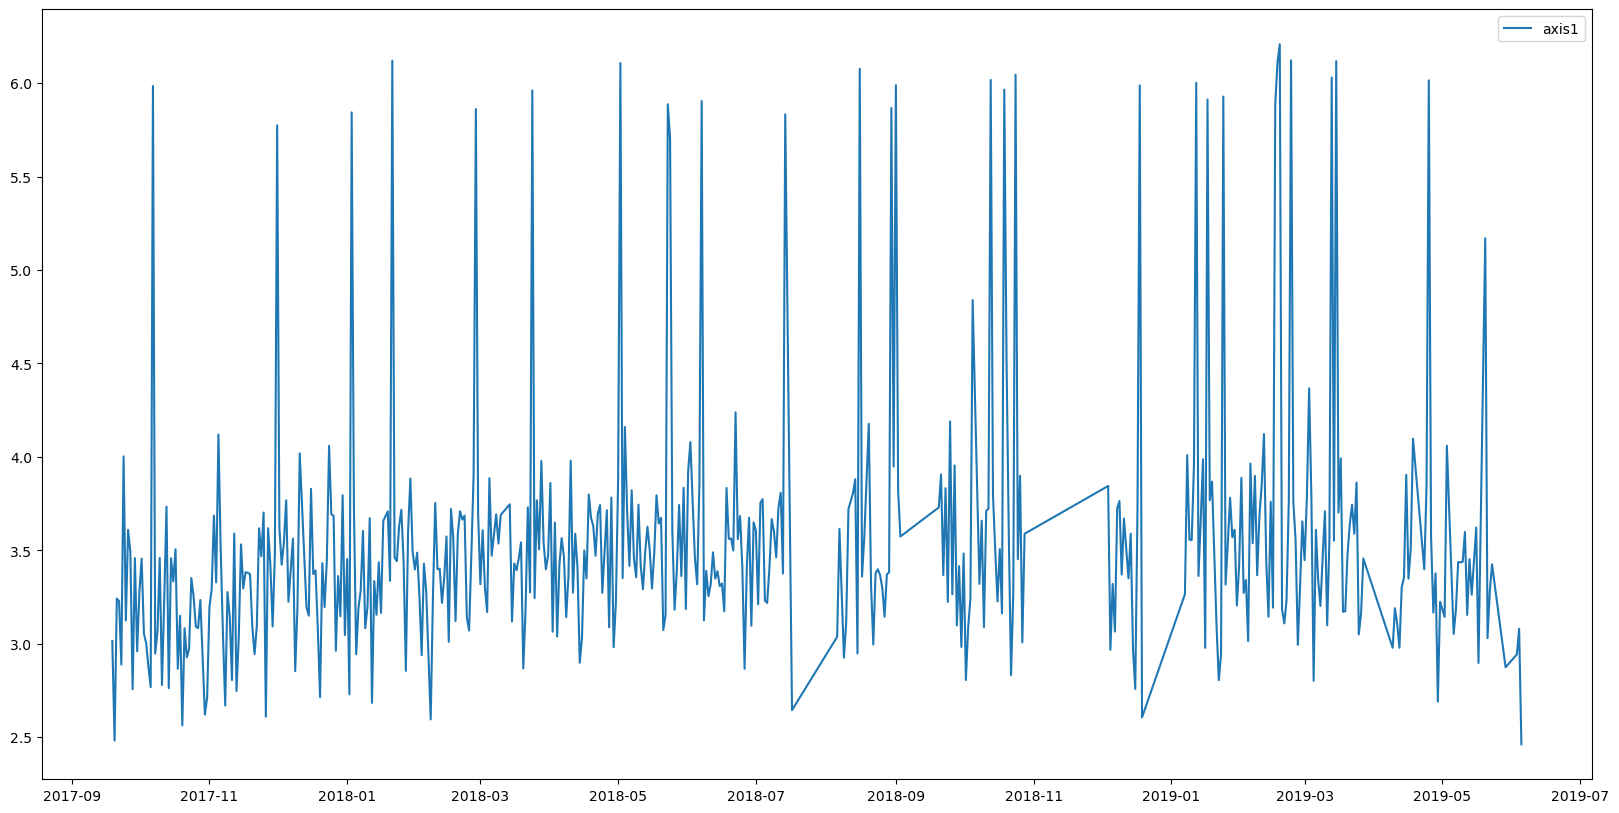

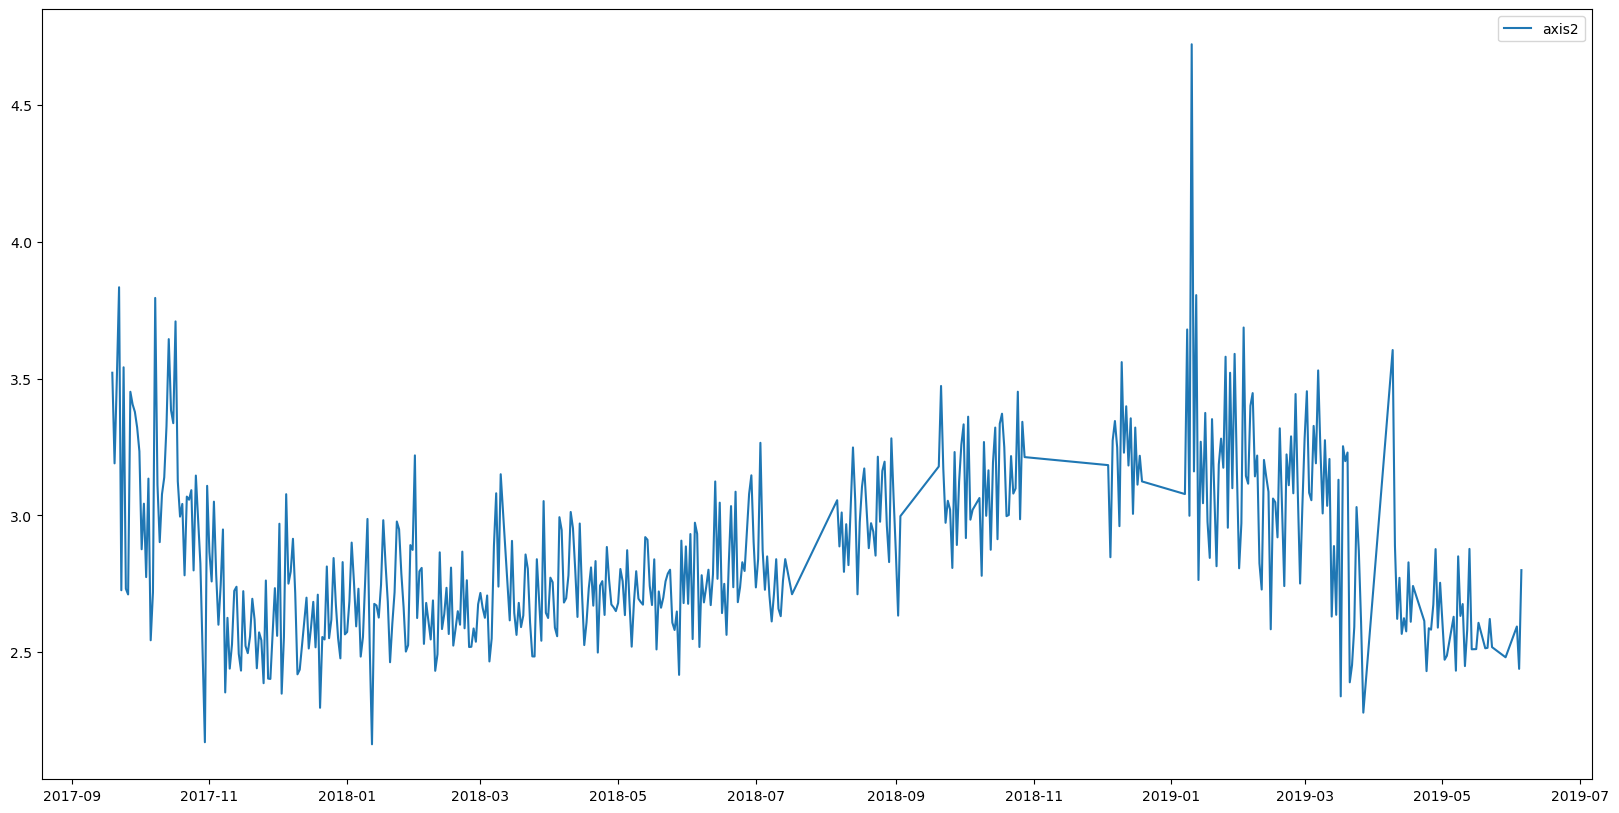

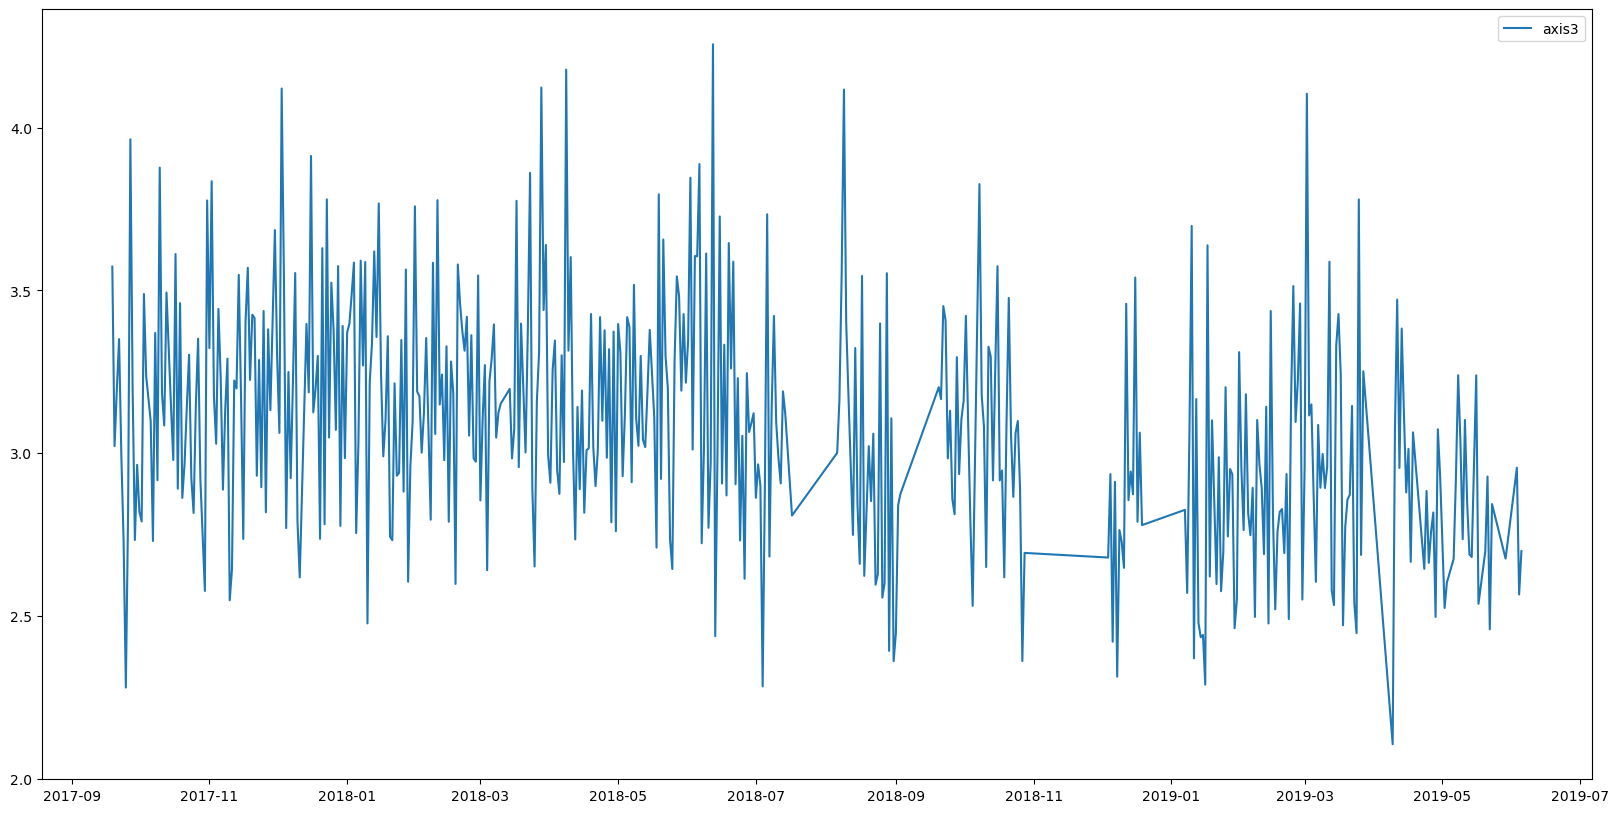

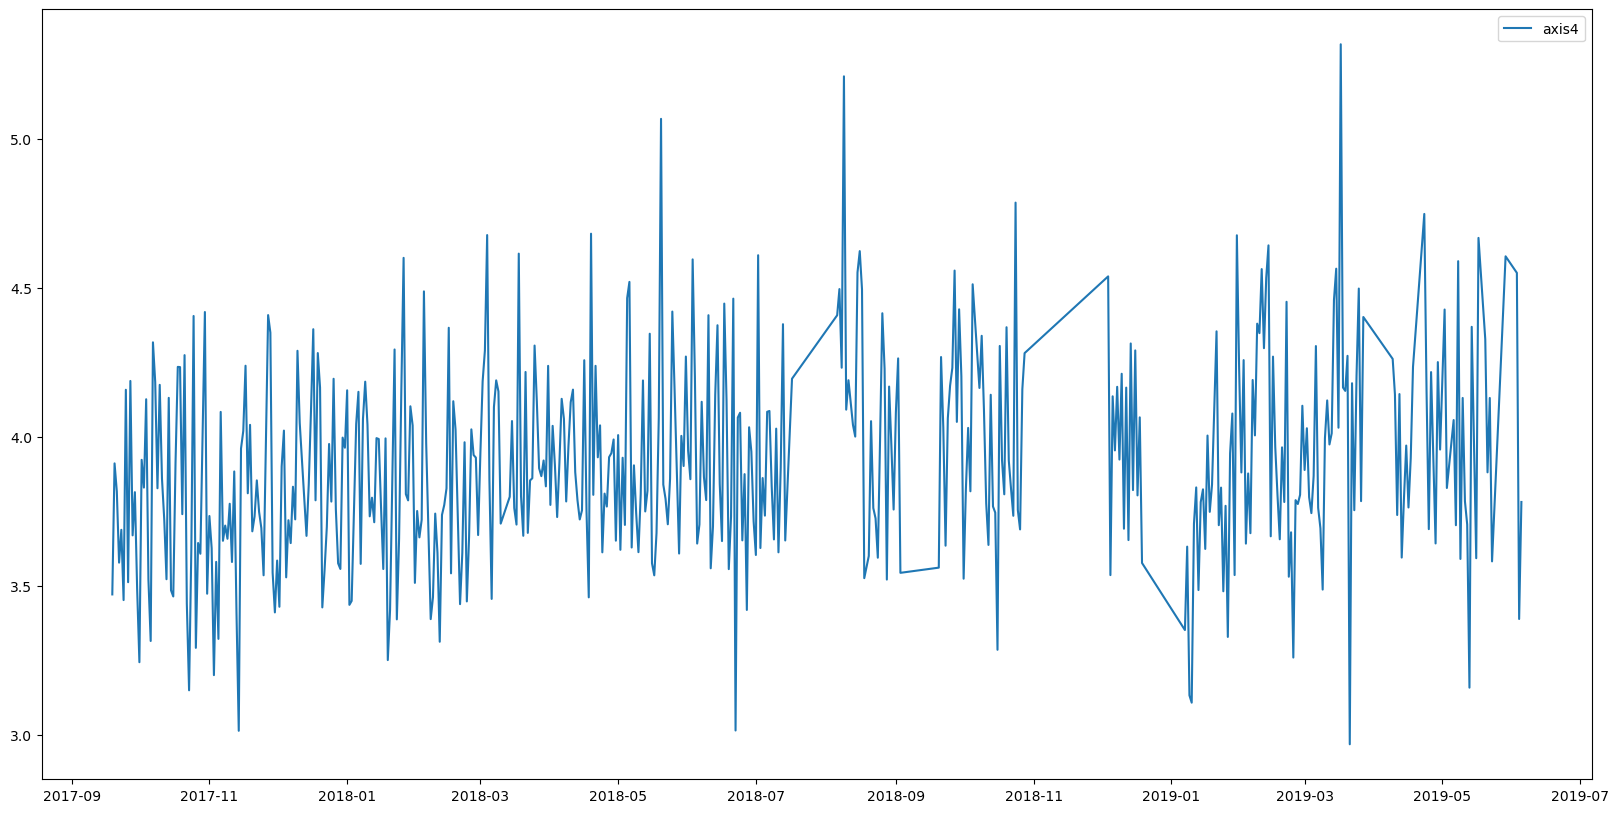

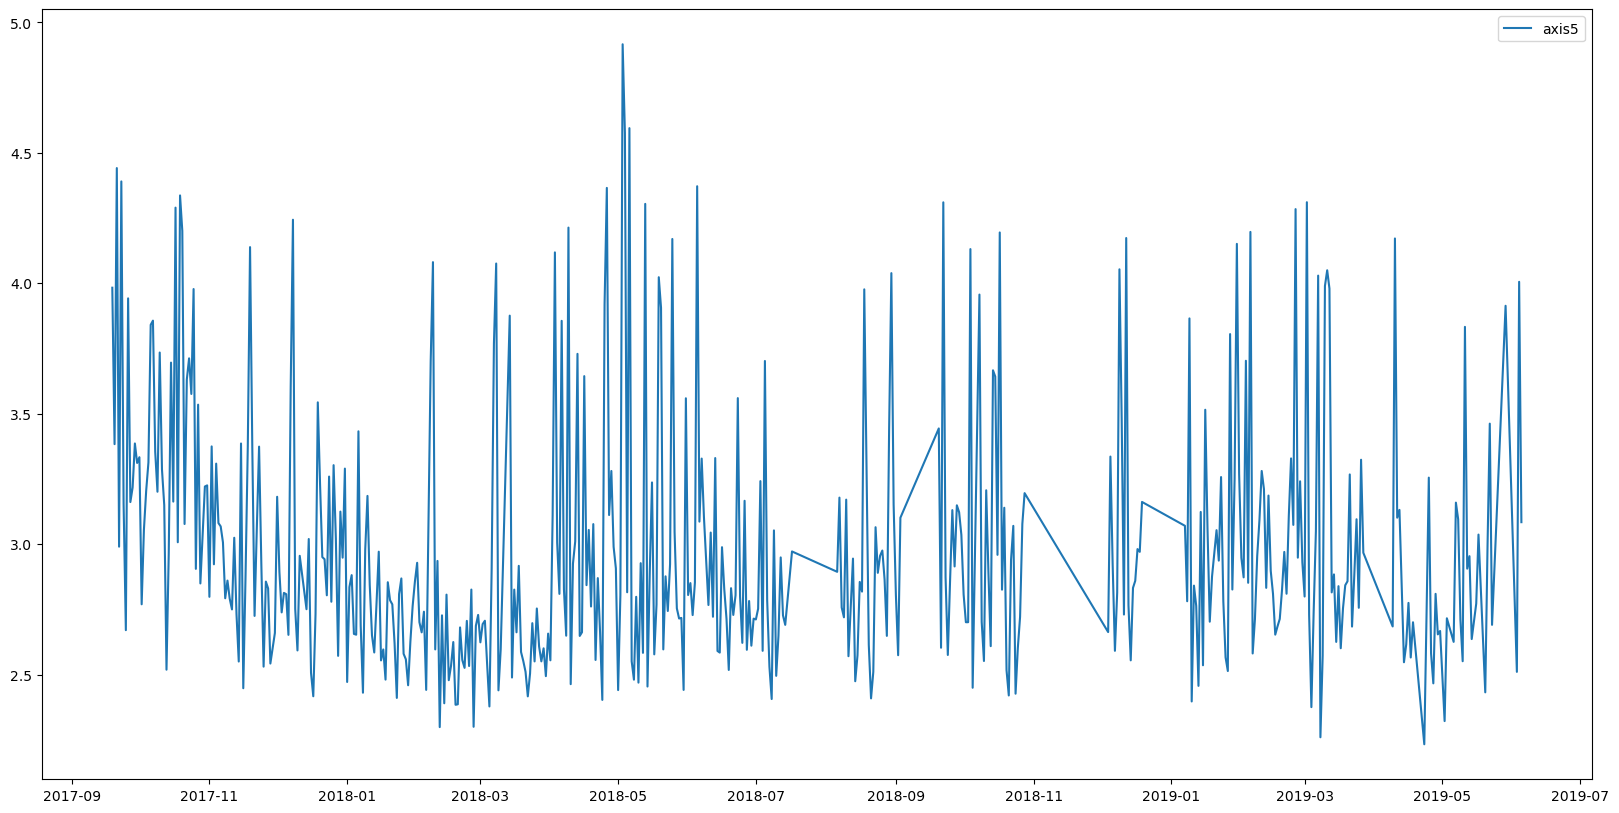

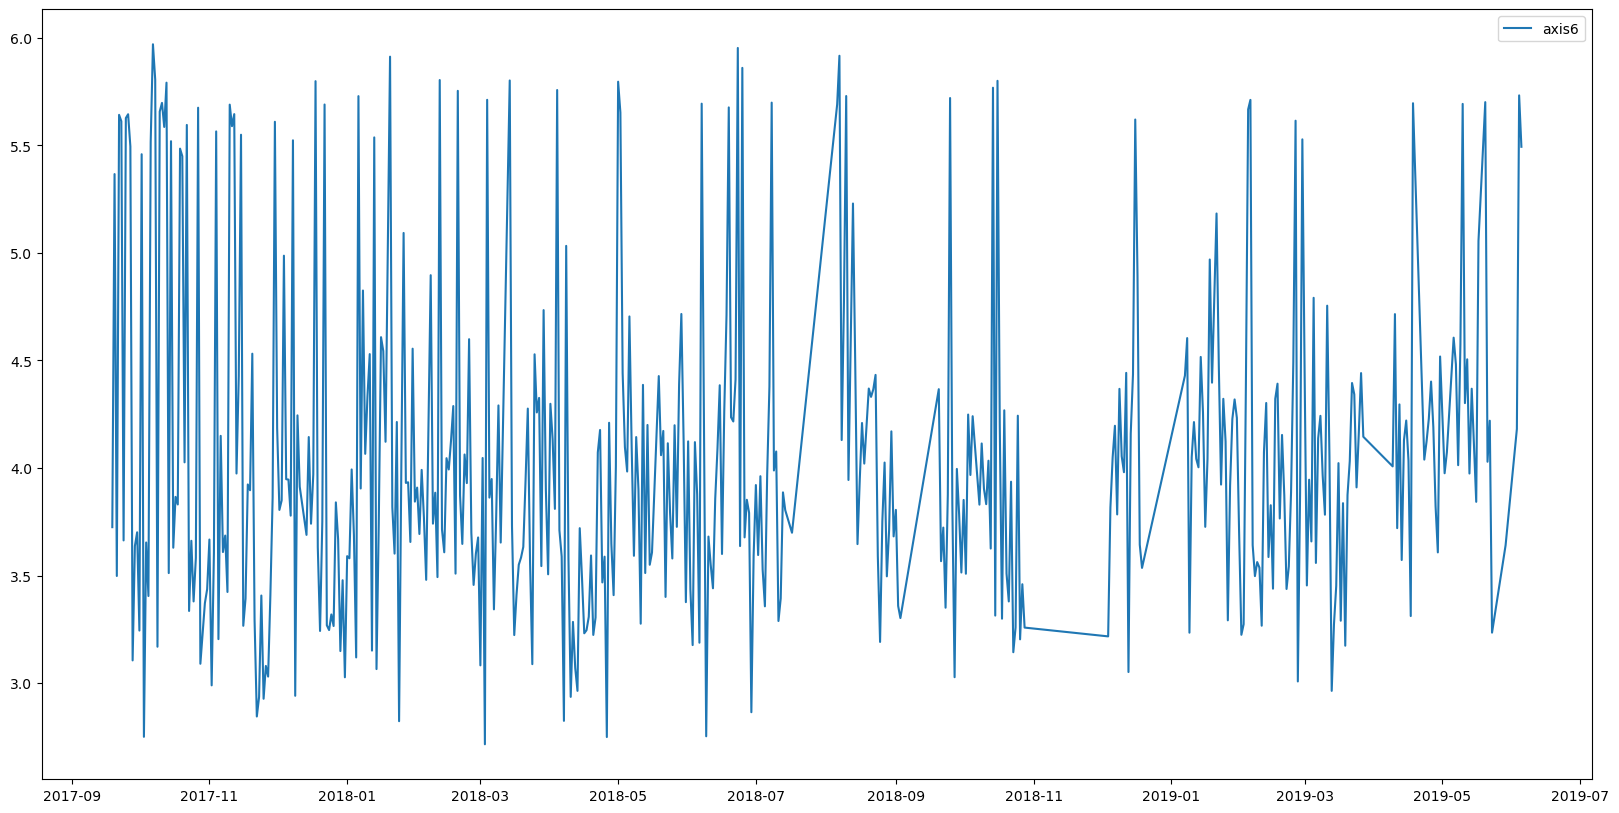

In [19]:
for i in columns:
    Crest_factor.plot(y=i, figsize=(20,10))


# Features for each axis

In [62]:
feature_axis1 = pd.concat([RMS_Value['axis1'],Skewness_value['axis1'],Kurtosis_value['axis1'],Stv['axis1'],Crest_factor['axis1'],Energy['axis1']],axis=1)
feature_axis1.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df1 = feature_axis1.drop(index=feature_axis1.index[0])
df1

RMS  Skewness  Kurtosis       Stv Crest_factor    Energy
2017-09-19  0.005251  0.044248 -0.150898  0.003618     3.014838  0.019937
2017-09-20  0.005337  0.034276 -0.032943  0.003057     2.481527  0.020596
2017-09-21  0.004315  0.089211  0.048127  0.002867      3.24202   0.01346
2017-09-22  0.003501  0.042439  0.118715  0.003057     3.228198  0.008864
2017-09-23   0.00403   0.05229 -0.210947   0.00312     2.888469  0.011745
...              ...       ...       ...       ...          ...       ...
2019-05-23  0.004399  0.205751 -0.221517  0.004308     3.424954  0.013993
2019-05-29  0.012233  0.202552 -0.570122  0.012207     2.873678   0.10819
2019-06-03  0.008896  0.087342 -0.487487  0.008827     2.942788  0.057219
2019-06-04   0.00707  0.079199 -0.206406  0.006897     3.080134  0.036141
2019-06-05  0.012681  0.119519  -0.66353  0.012648     2.461622  0.116266

[491 rows x 6 columns]

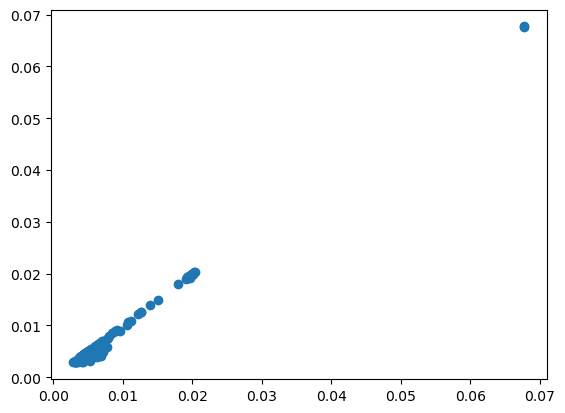

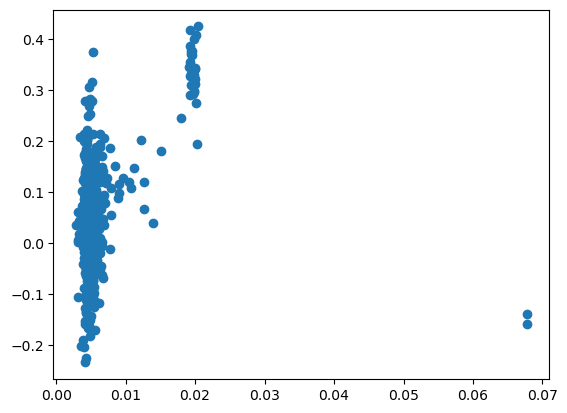

In [63]:
plt.scatter(df1['RMS'],df1['Stv'])
plt.show()
plt.scatter(df1['RMS'],df1['Skewness'])

In [64]:
feature_axis2 = pd.concat([RMS_Value['axis2'],Skewness_value['axis2'],Kurtosis_value['axis2'],Stv['axis2'],Crest_factor['axis2'],Energy['axis2']],axis=1)
feature_axis2.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df2 = feature_axis2.drop(index=feature_axis2.index[0])


In [65]:
feature_axis3 = pd.concat([RMS_Value['axis3'],Skewness_value['axis3'],Kurtosis_value['axis3'],Stv['axis3'],Crest_factor['axis3'],Energy['axis3']],axis=1)
feature_axis3.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df3 = feature_axis3.drop(index=feature_axis3.index[0])

In [66]:
feature_axis4 = pd.concat([RMS_Value['axis4'],Skewness_value['axis4'],Kurtosis_value['axis4'],Stv['axis4'],Crest_factor['axis4'],Energy['axis4']],axis=1)
feature_axis4.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df4 = feature_axis4.drop(index=feature_axis3.index[0])

In [67]:
feature_axis5 = pd.concat([RMS_Value['axis5'],Skewness_value['axis5'],Kurtosis_value['axis5'],Stv['axis5'],Crest_factor['axis5'],Energy['axis5']],axis=1)
feature_axis5.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df5 = feature_axis5.drop(index=feature_axis5.index[0])
df5

RMS  Skewness  Kurtosis       Stv Crest_factor    Energy
2017-09-19   0.02481  0.019406  1.697309    0.0246     3.982967  0.445044
2017-09-20  0.008761  0.059393  0.238528  0.008598     3.383435  0.055499
2017-09-21  0.010114 -0.235735  0.415331  0.009661      4.44138  0.073952
2017-09-22  0.009971  0.132416  0.150326   0.00992     2.990588  0.071883
2017-09-23  0.024103 -0.044722  1.930911  0.024078     4.390211  0.420039
...              ...       ...       ...       ...          ...       ...
2019-05-23  0.027957   0.53253  0.580891  0.021275     2.691049  0.565099
2019-05-29     0.017  0.584511  1.219108  0.015931     3.913701  0.208947
2019-06-03  0.028718  0.734397  0.999445  0.023067     2.510864  0.596257
2019-06-04   0.03113  0.301571  1.027898  0.029151     4.005579  0.700655
2019-06-05  0.022809  0.511994   0.90968  0.020765     3.084448   0.37615

[491 rows x 6 columns]

In [68]:
feature_axis6 = pd.concat([RMS_Value['axis6'],Skewness_value['axis6'],Kurtosis_value['axis6'],Stv['axis6'],Crest_factor['axis6'],Energy['axis6']],axis=1)
feature_axis6.columns = ['RMS','Skewness','Kurtosis','Stv','Crest_factor','Energy']

df6 = feature_axis6.drop(index=feature_axis6.index[0])
df6

RMS  Skewness  Kurtosis       Stv Crest_factor    Energy
2017-09-19  0.004015  0.178557  0.620124  0.003508     3.725304  0.011653
2017-09-20  0.020501  0.401172  7.308333  0.020381     5.366214  0.303868
2017-09-21  0.003665  0.019688  0.620211  0.003427     3.498431  0.009709
2017-09-22  0.020774  0.420651    7.4784  0.020507     5.641628   0.31201
2017-09-23  0.020597  0.384674  7.254864   0.02053     5.611709  0.306724
...              ...       ...       ...       ...          ...       ...
2019-05-23  0.005496   0.03774  0.997877  0.004571     3.235092  0.021838
2019-05-29  0.007532 -0.271721  2.083233  0.006179     3.640896  0.041012
2019-06-03  0.005009  0.223228  2.212812  0.004436     4.181497  0.018138
2019-06-04  0.022465  0.334116  7.203424  0.022145     5.731966  0.364894
2019-06-05  0.022166  0.427763  7.133988  0.022151     5.493046  0.355242

[491 rows x 6 columns]

In [69]:
from sklearn.cluster import KMeans

# Clustering between two features (each axis) 

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


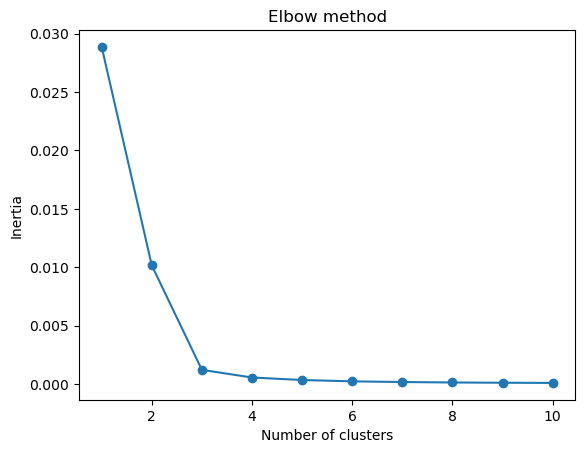

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0]


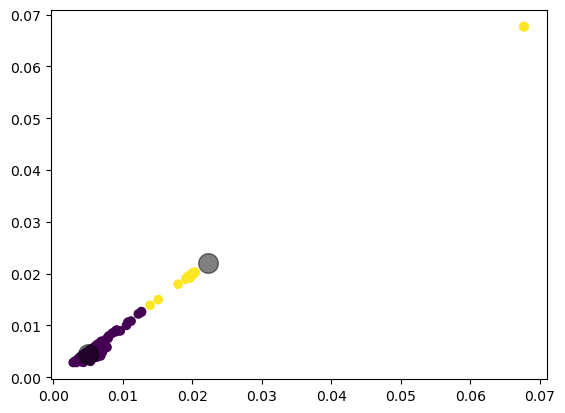

In [70]:
data = df1[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


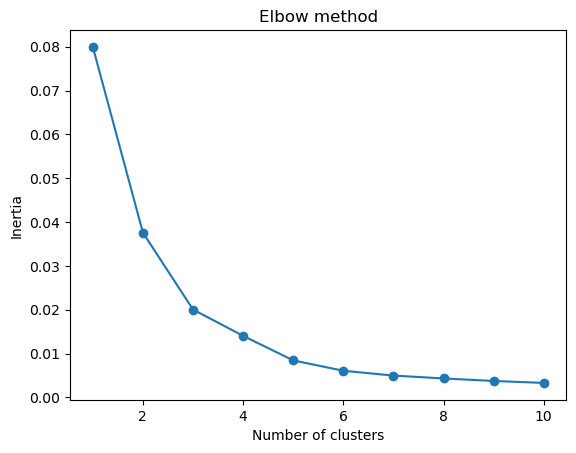

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


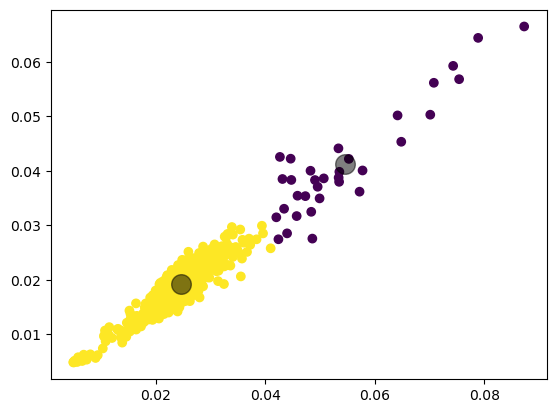

In [71]:
data = df2[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


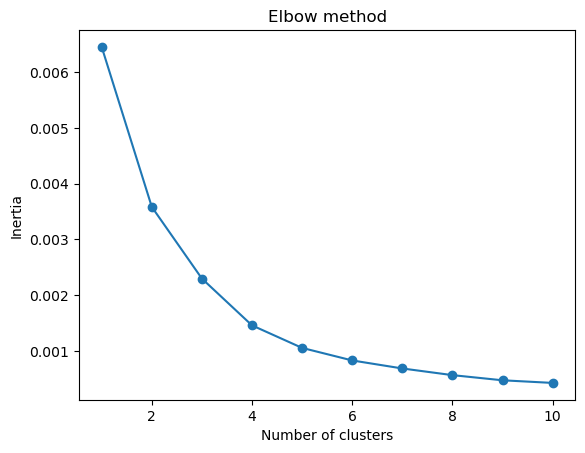

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


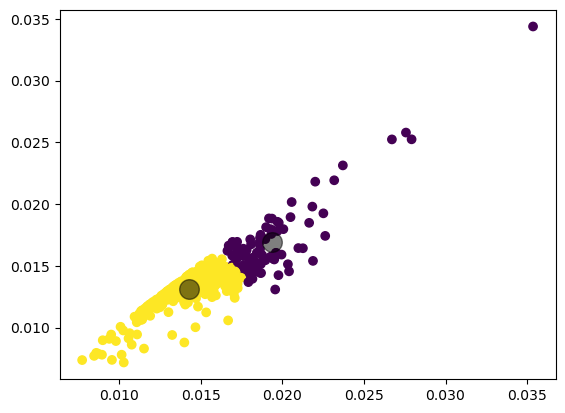

In [72]:
data = df3[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


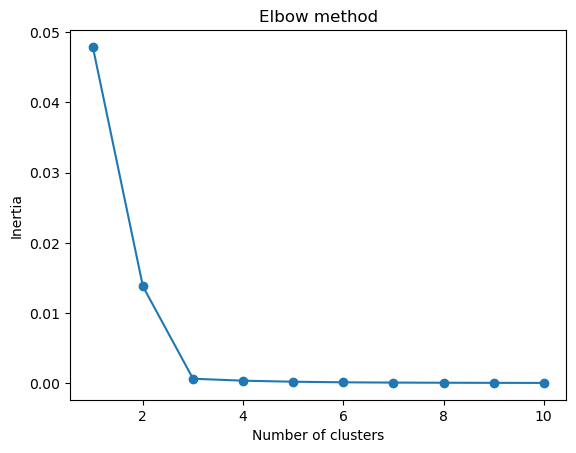

[0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0]


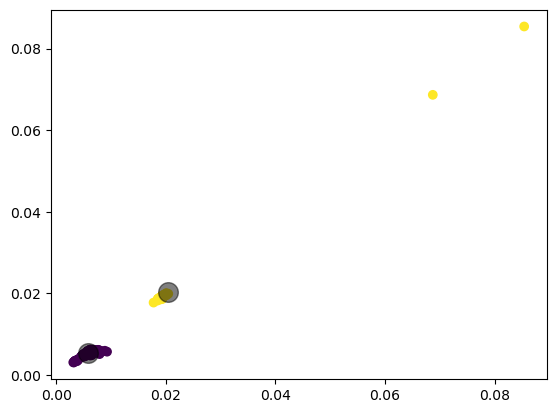

In [73]:
data = df4[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


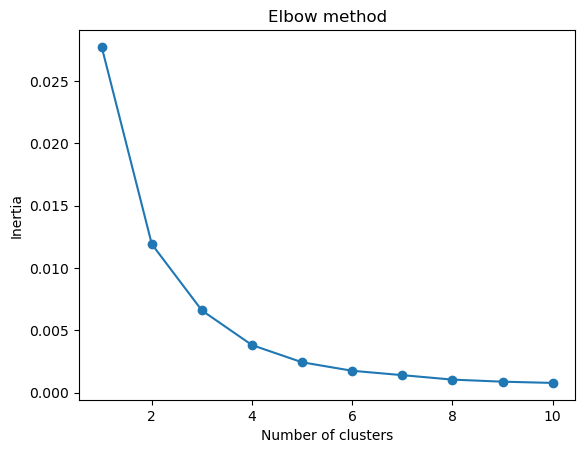

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 0 1]


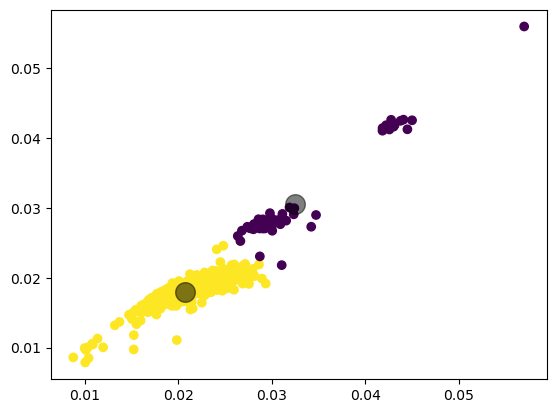

In [74]:
data = df5[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


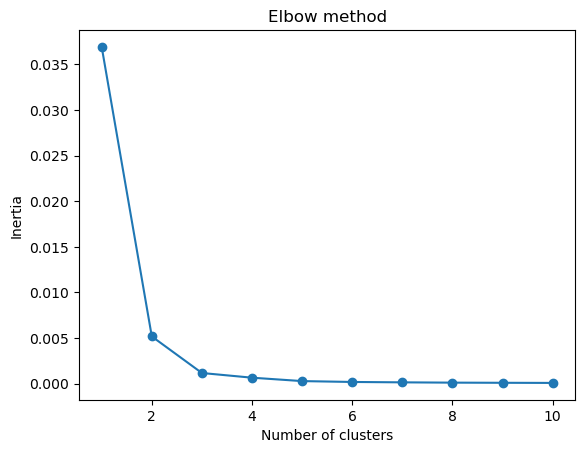

[0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 1]


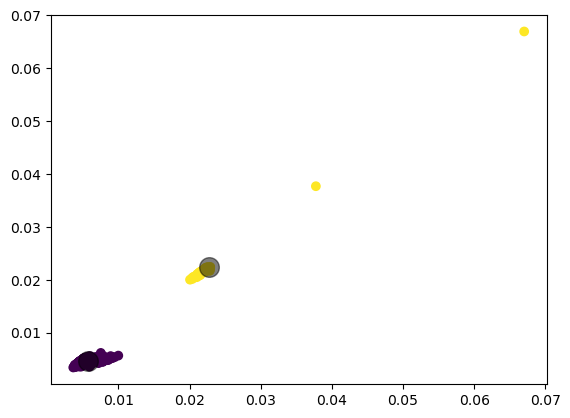

In [75]:
data = df6[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [76]:
feature = pd.concat([df1[['RMS','Stv']],df2[['RMS','Stv']],df3[['RMS','Stv']],df4[['RMS','Stv']],df5[['RMS','Stv']],df6[['RMS','Stv']]], axis=0)
feature

RMS       Stv
2017-09-19  0.005251  0.003618
2017-09-20  0.005337  0.003057
2017-09-21  0.004315  0.002867
2017-09-22  0.003501  0.003057
2017-09-23   0.00403   0.00312
...              ...       ...
2019-05-23  0.005496  0.004571
2019-05-29  0.007532  0.006179
2019-06-03  0.005009  0.004436
2019-06-04  0.022465  0.022145
2019-06-05  0.022166  0.022151

[2946 rows x 2 columns]

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


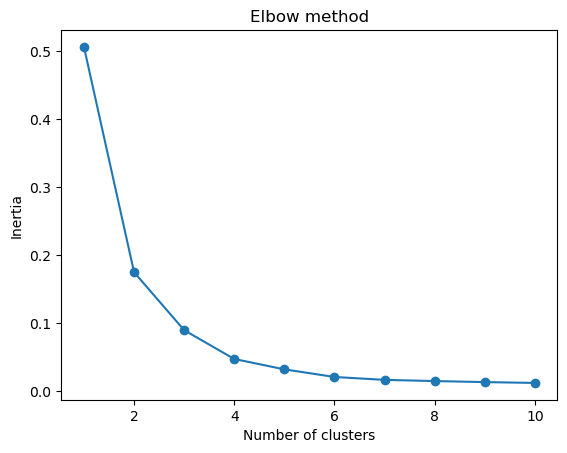

[0 0 0 ... 0 1 1]


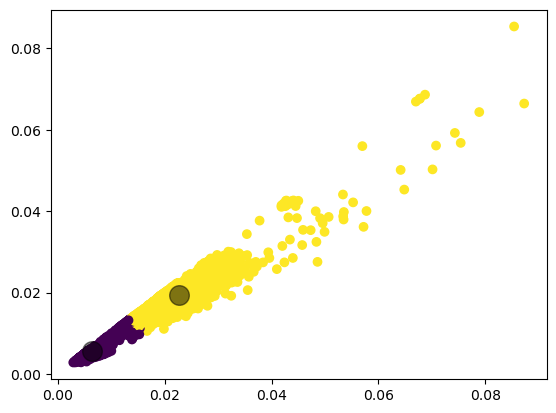

In [79]:
pd.set_option('max_colwidth',100)
inertias = []

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(feature)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(feature)

plt.scatter(feature['RMS'], feature['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [59]:
import datetime

d = datetime.date(2019, 5, 9)
print(d)
n = 0
df1
df = df1
df  

2019-05-09


RMS  Skewness  Kurtosis       Stv Crest_factor    Energy  \
2017-09-19  0.005251  0.044248 -0.150898  0.003618     3.014838  0.019937   
2017-09-20  0.005337  0.034276 -0.032943  0.003057     2.481527  0.020596   
2017-09-21  0.004315  0.089211  0.048127  0.002867      3.24202   0.01346   
2017-09-22  0.003501  0.042439  0.118715  0.003057     3.228198  0.008864   
2017-09-23   0.00403   0.05229 -0.210947   0.00312     2.888469  0.011745   
...              ...       ...       ...       ...          ...       ...   
2019-05-23  0.004399  0.205751 -0.221517  0.004308     3.424954  0.013993   
2019-05-29  0.012233  0.202552 -0.570122  0.012207     2.873678   0.10819   
2019-06-03  0.008896  0.087342 -0.487487  0.008827     2.942788  0.057219   
2019-06-04   0.00707  0.079199 -0.206406  0.006897     3.080134  0.036141   
2019-06-05  0.012681  0.119519  -0.66353  0.012648     2.461622  0.116266   

            Anomaly  
2017-09-19     True  
2017-09-20     True  
2017-09-21     True  
2017-09-22     True  
2017-09-23     True  
...             ...  
2019-05-23    False  
2019-05-29    False  
2019-06-03    False  
2019-06-04    False  
2019-06-05    False  

[491 rows x 7 columns]

In [58]:

df.insert(6, 'Anomaly', value = [True if i < d else False for i in df1.index])
df

RMS  Skewness  Kurtosis       Stv Crest_factor    Energy  \
2017-09-19  0.005251  0.044248 -0.150898  0.003618     3.014838  0.019937   
2017-09-20  0.005337  0.034276 -0.032943  0.003057     2.481527  0.020596   
2017-09-21  0.004315  0.089211  0.048127  0.002867      3.24202   0.01346   
2017-09-22  0.003501  0.042439  0.118715  0.003057     3.228198  0.008864   
2017-09-23   0.00403   0.05229 -0.210947   0.00312     2.888469  0.011745   
...              ...       ...       ...       ...          ...       ...   
2019-05-23  0.004399  0.205751 -0.221517  0.004308     3.424954  0.013993   
2019-05-29  0.012233  0.202552 -0.570122  0.012207     2.873678   0.10819   
2019-06-03  0.008896  0.087342 -0.487487  0.008827     2.942788  0.057219   
2019-06-04   0.00707  0.079199 -0.206406  0.006897     3.080134  0.036141   
2019-06-05  0.012681  0.119519  -0.66353  0.012648     2.461622  0.116266   

            Anomaly  
2017-09-19     True  
2017-09-20     True  
2017-09-21     True  
2017-09-22     True  
2017-09-23     True  
...             ...  
2019-05-23    False  
2019-05-29    False  
2019-06-03    False  
2019-06-04    False  
2019-06-05    False  

[491 rows x 7 columns]

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


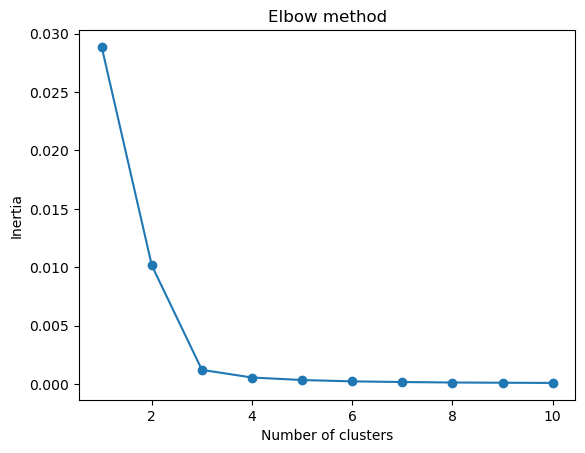

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1]


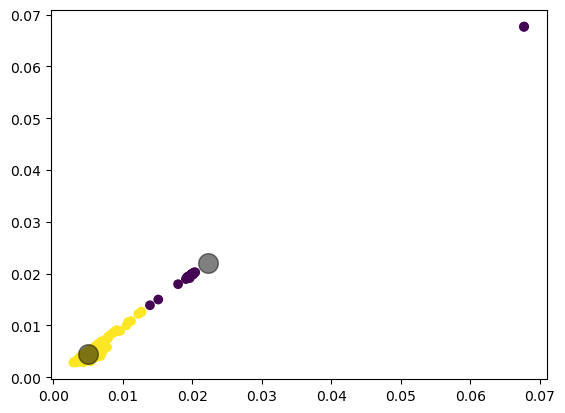

In [60]:
data = df[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [36]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(feature_axis2)

plt.scatter(feature_axis2['RMS'], feature_axis2['Skewness'],c=kmeans.labels_)
plt.show()
plt.plot(feature_axis1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
d1,d2,d3,d4,d5,d6 = [],[],[],[],[],[]
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
divergence_kullbackleibler = pd.DataFrame(columns=columns)
conditional_entropy = pd.DataFrame(columns=columns)
entropy = pd.DataFrame(columns=columns)
mutual_information = pd.DataFrame(columns=columns)
Jensen_Shannon_divergence = pd.DataFrame(columns=columns)
i = 0    
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    print(route)
    if '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip' in route:
        ref1,ref2,ref3,ref4,ref5,ref6 = find_reference_point(route)
    else:
        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        DATA1 = series.normalized_torque()
                        print(ref1)
                        divergence_kullbackleibler.loc[i, 'axis1'] = drv.entropy_conditional(ref1,DATA1)
                        break
#                         Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1)
#                         Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1)
#                         Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1)
#                     elif ax2 in file:
#                     # Extract features for axis1
#                         DATA2 = series.torque
#                         d2 = np.concatenate((d2,DATA2), axis=None)
#                         RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                         Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2)
#                         Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2)
#                         Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                     elif ax3 in file:
#                     # Extract features for axis1
#                         DATA3 = series.torque
#                         d3 = np.concatenate((d3,DATA3), axis=None)
#                         RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                         Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3)
#                         Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3)
#                         Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                     elif ax4 in file:
#                     # Extract features for axis1
#                         DATA4 = series.torque
#                         d4 = np.concatenate((d4,DATA4), axis=None)
#                         RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                         Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4)
#                         Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4)
#                         Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                     elif ax5 in file:
#                     # Extract features for axis1
#                         DATA5 = series.torque
#                         d5 = np.concatenate((d5,DATA5), axis=None)
#                         RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                         Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5)
#                         Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5)
#                         Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                     elif ax6 in file:
#                     # Extract features for axis1
#                         DATA6 = series.torque
#                         d6 = np.concatenate((d6,DATA6), axis=None)
#                         RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#                         Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6)
#                         Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6)
#                         Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#             i = i + 1
               

In [ ]:
A = DATA1-ref1
A

In [ ]:
np.sum(rel_entr(DATA1,ref1))


In [ ]:
plt.figure(figsize=(10,2))
plt.plot(DATA1)
plt.plot(ref1)
# drv.entropy_conditional(ref1, DATA1)

In [ ]:
len(DATA1)